In [558]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
import itertools

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf 
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_process import arma_generate_sample

from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima import model_selection

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import OneHotEncoder

In [99]:
data = pd.read_csv('./data/zillow_data.csv')

In [404]:
df_weekly = pd.read_csv('./data/zillow_weekly_data.csv')

In [458]:
df_weekly

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-02,2008-02-09,2008-02-16,2008-02-23,2008-03-01,...,2023-04-01,2023-04-08,2023-04-15,2023-04-22,2023-04-29,2023-05-06,2023-05-13,2023-05-20,2023-05-27,2023-06-03
0,102001,0,United States,country,NaN,184169.0,180000.0,180000.0,177000.0,182500.0,...,348000.0,349900.0,349000.0,350000.0,350000.0,357000.0,352000.0,360000.0,360000.0,370000.0
1,394913,1,"New York, NY",msa,NY,392000.0,412500.0,410000.0,406850.0,389500.0,...,518750.0,540000.0,530000.0,550000.0,540000.0,561750.0,565000.0,560000.0,568255.0,580000.0
2,753899,2,"Los Angeles, CA",msa,CA,475000.0,500000.0,519000.0,520750.0,482000.0,...,857500.0,842250.0,850000.0,850000.0,850000.0,877500.0,850000.0,870000.0,880000.0,895500.0
3,394463,3,"Chicago, IL",msa,IL,239500.0,240000.0,240000.0,225000.0,240000.0,...,301250.0,296000.0,307000.0,304000.0,310500.0,310000.0,312500.0,315000.0,320000.0,342000.0
4,394514,4,"Dallas, TX",msa,TX,137550.0,124950.0,140080.0,136000.0,138000.0,...,375000.0,385000.0,379250.0,385000.0,390000.0,390000.0,389000.0,405000.0,390000.0,405000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,394917,282,"Niles, MI",msa,MI,NaN,NaN,NaN,NaN,NaN,...,258500.0,250000.0,182000.0,230000.0,195500.0,280000.0,257500.0,289950.0,288000.0,339500.0
188,394685,289,"Homosassa Springs, FL",msa,FL,NaN,NaN,NaN,NaN,NaN,...,264950.0,286000.0,269750.0,266500.0,290000.0,260000.0,264000.0,294000.0,293000.0,266150.0
189,394442,321,"Carbondale, IL",msa,IL,NaN,NaN,NaN,NaN,NaN,...,134950.0,115000.0,114900.0,116900.0,164500.0,140000.0,115000.0,132750.0,109000.0,132950.0
190,394890,327,"Mount Vernon, WA",msa,WA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,460000.0,548000.0,530000.0


In [462]:
df_weekly.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       '2008-02-02', '2008-02-09', '2008-02-16', '2008-02-23', '2008-03-01',
       ...
       '2023-04-01', '2023-04-08', '2023-04-15', '2023-04-22', '2023-04-29',
       '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27', '2023-06-03'],
      dtype='object', length=806)

In [469]:
def melt_data_weekly(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [478]:
weekly_melt =  melt_data_weekly(df_weekly)
weekly_melt.set_index('time', inplace = True)
weekly_melt.index = pd.to_datetime(weekly_melt.index)
weekly_melt.rename(columns = {'value':'Price'}, inplace = True)

In [520]:
weekly_melt['StateName'].str.replace('NaN', 'USA', regex = True)

time
2008-02-02    NaN
2008-02-02     NY
2008-02-02     CA
2008-02-02     IL
2008-02-02     TX
             ... 
2023-06-03     MI
2023-06-03     FL
2023-06-03     IL
2023-06-03     WA
2023-06-03     AZ
Name: StateName, Length: 122086, dtype: object

In [543]:
weekly_melt[weekly_melt['RegionName'] == 'United States']['StateName'].astype(str)

time
2008-02-02    nan
2008-02-09    nan
2008-02-16    nan
2008-02-23    nan
2008-03-01    nan
             ... 
2023-05-06    nan
2023-05-13    nan
2023-05-20    nan
2023-05-27    nan
2023-06-03    nan
Name: StateName, Length: 801, dtype: object

In [545]:
weekly_melt['State'] = weekly_melt['StateName']

In [546]:
weekly_melt

,RegionID,SizeRank,RegionName,RegionType,StateName,Price,State
time,,,,,,,
2008-02-02,102001,0,United States,country,NaN,184169.0,NaN
2008-02-02,394913,1,"New York, NY",msa,NY,392000.0,NY
2008-02-02,753899,2,"Los Angeles, CA",msa,CA,475000.0,CA
2008-02-02,394463,3,"Chicago, IL",msa,IL,239500.0,IL
2008-02-02,394514,4,"Dallas, TX",msa,TX,137550.0,TX
...,...,...,...,...,...,...,...
2023-06-03,394917,282,"Niles, MI",msa,MI,339500.0,MI
2023-06-03,394685,289,"Homosassa Springs, FL",msa,FL,266150.0,FL
2023-06-03,394442,321,"Carbondale, IL",msa,IL,132950.0,IL


In [524]:
weekly_melt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122086 entries, 2008-02-02 to 2023-06-03
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionID    122086 non-null  int64  
 1   SizeRank    122086 non-null  int64  
 2   RegionName  122086 non-null  object 
 3   RegionType  122086 non-null  object 
 4   StateName   121285 non-null  object 
 5   Price       122086 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 6.5+ MB


In [516]:
weekly_melt.apply(if weekly_melt['RegionName'] == 'United States'

time
2008-02-02     True
2008-02-02    False
2008-02-02    False
2008-02-02    False
2008-02-02    False
              ...  
2023-06-03    False
2023-06-03    False
2023-06-03    False
2023-06-03    False
2023-06-03    False
Name: RegionName, Length: 122086, dtype: bool

In [512]:
weekly_melt['StateName'].unique()[0]

float

<Axes: xlabel='time'>

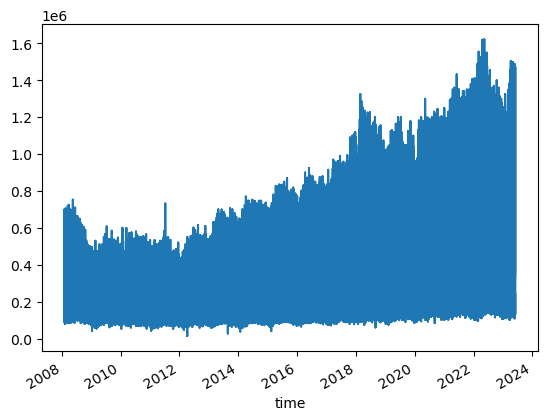

In [496]:
weekly_melt['Price'].plot()

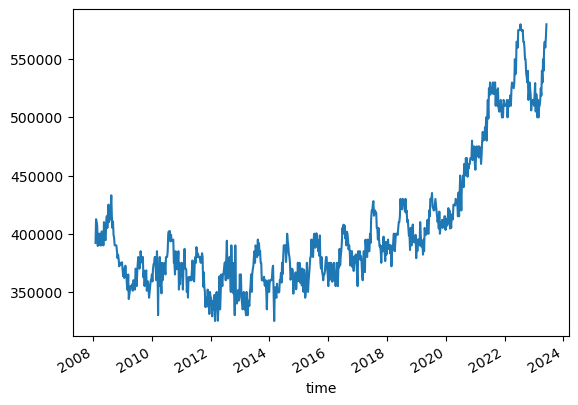

In [630]:
weekly_melt[weekly_melt['RegionName'] == 'New York, NY']['Price'].plot();

In [608]:
weekly_melt['StateName'].unique()

array([nan, 'NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ',
       'MI', 'MN', 'CO', 'MD', 'MO', 'NC', 'OR', 'OH', 'NV', 'IN', 'TN',
       'RI', 'WI', 'OK', 'KY', 'UT', 'CT', 'AL', 'HI', 'NE', 'SC', 'NM',
       'ID', 'AR', 'MS', 'ME', 'LA', 'DE', 'WA', 'NJ'], dtype=object)

<Axes: xlabel='time'>

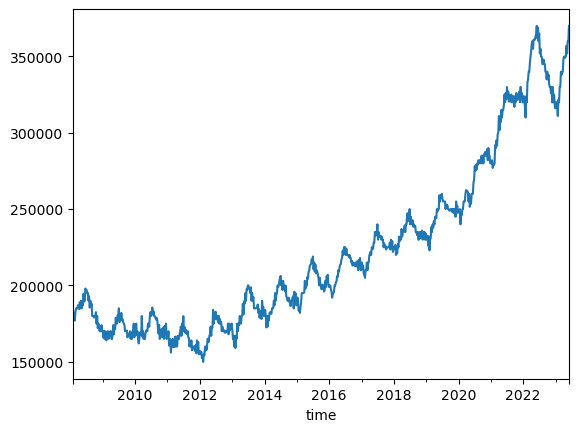

In [488]:
weekly_melt[weekly_melt['RegionName'] == 'United States']['Price'].plot()

In [664]:
states = list(weekly_melt['StateName'].unique())

In [665]:
type(states)

list

In [666]:
onehot_enc = OneHotEncoder(sparse = True, handle_unknown = 'ignore')

In [667]:
ohe

OneHotEncoder()

In [668]:
ohe_df = onehot_enc.fit_transform(weekly_melt[['StateName']])

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [669]:
ohe

OneHotEncoder()

In [670]:
nominal_df = pd.DataFrame(ohe_df.toarray(),columns = onehot_enc.get_feature_names_out())


In [671]:
nominal_df

,StateName_AL,StateName_AR,StateName_AZ,StateName_CA,StateName_CO,StateName_CT,StateName_DE,StateName_FL,StateName_GA,StateName_HI,...,StateName_PA,StateName_RI,StateName_SC,StateName_TN,StateName_TX,StateName_UT,StateName_VA,StateName_WA,StateName_WI,StateName_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [672]:
weekly_melt.shape

(122086, 7)

In [673]:
nominal_df.shape

(122086, 41)

In [674]:
nominal_df.set_index(weekly_melt.index, inplace = True)

In [675]:
nominal_df.columns[-1]

'StateName_nan'

In [676]:
data_ohe = pd.concat([weekly_melt, nominal_df], axis = 1)

In [677]:
data_ohe.rename(columns = {'StateName_nan': 'StateName_USA'}, inplace = True)

In [678]:
data_ohe

,RegionID,SizeRank,RegionName,RegionType,StateName,Price,State,StateName_AL,StateName_AR,StateName_AZ,...,StateName_PA,StateName_RI,StateName_SC,StateName_TN,StateName_TX,StateName_UT,StateName_VA,StateName_WA,StateName_WI,StateName_USA
time,,,,,,,,,,,,,,,,,,,,,
2008-02-02,102001,0,United States,country,NaN,184169.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2008-02-02,394913,1,"New York, NY",msa,NY,392000.0,NY,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-02-02,753899,2,"Los Angeles, CA",msa,CA,475000.0,CA,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-02-02,394463,3,"Chicago, IL",msa,IL,239500.0,IL,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-02-02,394514,4,"Dallas, TX",msa,TX,137550.0,TX,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-03,394917,282,"Niles, MI",msa,MI,339500.0,MI,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-03,394685,289,"Homosassa Springs, FL",msa,FL,266150.0,FL,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-03,394442,321,"Carbondale, IL",msa,IL,132950.0,IL,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [681]:
data_ohe = data_ohe.drop(columns = ['StateName', 'State'])

In [682]:
data_ohe.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'Price',
       'StateName_AL', 'StateName_AR', 'StateName_AZ', 'StateName_CA',
       'StateName_CO', 'StateName_CT', 'StateName_DE', 'StateName_FL',
       'StateName_GA', 'StateName_HI', 'StateName_ID', 'StateName_IL',
       'StateName_IN', 'StateName_KY', 'StateName_LA', 'StateName_MA',
       'StateName_MD', 'StateName_ME', 'StateName_MI', 'StateName_MN',
       'StateName_MO', 'StateName_MS', 'StateName_NC', 'StateName_NE',
       'StateName_NJ', 'StateName_NM', 'StateName_NV', 'StateName_NY',
       'StateName_OH', 'StateName_OK', 'StateName_OR', 'StateName_PA',
       'StateName_RI', 'StateName_SC', 'StateName_TN', 'StateName_TX',
       'StateName_UT', 'StateName_VA', 'StateName_WA', 'StateName_WI',
       'StateName_USA'],
      dtype='object')

In [684]:
data_ohe

,RegionID,SizeRank,RegionName,RegionType,Price,StateName_AL,StateName_AR,StateName_AZ,StateName_CA,StateName_CO,...,StateName_PA,StateName_RI,StateName_SC,StateName_TN,StateName_TX,StateName_UT,StateName_VA,StateName_WA,StateName_WI,StateName_USA
time,,,,,,,,,,,,,,,,,,,,,
2008-02-02,102001,0,United States,country,184169.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2008-02-02,394913,1,"New York, NY",msa,392000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-02-02,753899,2,"Los Angeles, CA",msa,475000.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-02-02,394463,3,"Chicago, IL",msa,239500.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-02-02,394514,4,"Dallas, TX",msa,137550.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-03,394917,282,"Niles, MI",msa,339500.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-03,394685,289,"Homosassa Springs, FL",msa,266150.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-03,394442,321,"Carbondale, IL",msa,132950.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [685]:
data_ohe.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'Price',
       'StateName_AL', 'StateName_AR', 'StateName_AZ', 'StateName_CA',
       'StateName_CO', 'StateName_CT', 'StateName_DE', 'StateName_FL',
       'StateName_GA', 'StateName_HI', 'StateName_ID', 'StateName_IL',
       'StateName_IN', 'StateName_KY', 'StateName_LA', 'StateName_MA',
       'StateName_MD', 'StateName_ME', 'StateName_MI', 'StateName_MN',
       'StateName_MO', 'StateName_MS', 'StateName_NC', 'StateName_NE',
       'StateName_NJ', 'StateName_NM', 'StateName_NV', 'StateName_NY',
       'StateName_OH', 'StateName_OK', 'StateName_OR', 'StateName_PA',
       'StateName_RI', 'StateName_SC', 'StateName_TN', 'StateName_TX',
       'StateName_UT', 'StateName_VA', 'StateName_WA', 'StateName_WI',
       'StateName_USA'],
      dtype='object')

In [686]:
def date_features(df):
    """
    Data features for time series analysis
    """
    df = df.copy()
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear

    return df

In [693]:
data_ohe.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'Price',
       'StateName_AL', 'StateName_AR', 'StateName_AZ', 'StateName_CA',
       'StateName_CO', 'StateName_CT', 'StateName_DE', 'StateName_FL',
       'StateName_GA', 'StateName_HI', 'StateName_ID', 'StateName_IL',
       'StateName_IN', 'StateName_KY', 'StateName_LA', 'StateName_MA',
       'StateName_MD', 'StateName_ME', 'StateName_MI', 'StateName_MN',
       'StateName_MO', 'StateName_MS', 'StateName_NC', 'StateName_NE',
       'StateName_NJ', 'StateName_NM', 'StateName_NV', 'StateName_NY',
       'StateName_OH', 'StateName_OK', 'StateName_OR', 'StateName_PA',
       'StateName_RI', 'StateName_SC', 'StateName_TN', 'StateName_TX',
       'StateName_UT', 'StateName_VA', 'StateName_WA', 'StateName_WI',
       'StateName_USA'],
      dtype='object')

In [775]:
data_ohe

,RegionID,SizeRank,RegionName,RegionType,Price,StateName_AL,StateName_AR,StateName_AZ,StateName_CA,StateName_CO,...,StateName_PA,StateName_RI,StateName_SC,StateName_TN,StateName_TX,StateName_UT,StateName_VA,StateName_WA,StateName_WI,StateName_USA
time,,,,,,,,,,,,,,,,,,,,,
2008-02-02,102001,0,United States,country,184169.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2008-02-02,394913,1,"New York, NY",msa,392000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-02-02,753899,2,"Los Angeles, CA",msa,475000.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-02-02,394463,3,"Chicago, IL",msa,239500.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-02-02,394514,4,"Dallas, TX",msa,137550.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-03,394917,282,"Niles, MI",msa,339500.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-03,394685,289,"Homosassa Springs, FL",msa,266150.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-03,394442,321,"Carbondale, IL",msa,132950.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [688]:
train_data = data_ohe.loc[data_ohe.index < '2020-01-01']
test_data = data_ohe.loc[data_ohe.index >= '2020-01-01']

In [692]:
train_data = date_features(train_data)
test_data = date_features(test_data)

In [694]:
features =  ['year', 'quarter', 'month', 'dayofyear', 'StateName_AL', 'StateName_AR', 'StateName_AZ', 'StateName_CA',
       'StateName_CO', 'StateName_CT', 'StateName_DE', 'StateName_FL',
       'StateName_GA', 'StateName_HI', 'StateName_ID', 'StateName_IL',
       'StateName_IN', 'StateName_KY', 'StateName_LA', 'StateName_MA',
       'StateName_MD', 'StateName_ME', 'StateName_MI', 'StateName_MN',
       'StateName_MO', 'StateName_MS', 'StateName_NC', 'StateName_NE',
       'StateName_NJ', 'StateName_NM', 'StateName_NV', 'StateName_NY',
       'StateName_OH', 'StateName_OK', 'StateName_OR', 'StateName_PA',
       'StateName_RI', 'StateName_SC', 'StateName_TN', 'StateName_TX',
       'StateName_UT', 'StateName_VA', 'StateName_WA', 'StateName_WI',
       'StateName_USA']

target = ['Price']

In [707]:
train_data['Price']

time
2008-02-02    184169.0
2008-02-02    392000.0
2008-02-02    475000.0
2008-02-02    239500.0
2008-02-02    137550.0
                ...   
2019-12-28    399999.0
2019-12-28    194450.0
2019-12-28    215000.0
2019-12-28    125000.0
2019-12-28    159950.0
Name: Price, Length: 91638, dtype: float64

In [708]:
X_train = train_data[features]
y_train = train_data['Price']

X_test = test_data[features]
y_test = test_data['Price']

In [734]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:165172.15649	validation_1-rmse:283695.00587
[1]	validation_0-rmse:126303.15814	validation_1-rmse:236953.52714
[2]	validation_0-rmse:101726.23683	validation_1-rmse:206044.64782
[3]	validation_0-rmse:86880.92488	validation_1-rmse:183383.30680


/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:78286.95027	validation_1-rmse:170651.29141
[5]	validation_0-rmse:73375.96364	validation_1-rmse:161474.84056
[6]	validation_0-rmse:70585.04879	validation_1-rmse:153528.72711
[7]	validation_0-rmse:68899.87485	validation_1-rmse:148788.23687
[8]	validation_0-rmse:67900.97468	validation_1-rmse:145679.65169
[9]	validation_0-rmse:67269.98882	validation_1-rmse:143718.99574
[10]	validation_0-rmse:66691.07930	validation_1-rmse:141739.77292
[11]	validation_0-rmse:66362.68857	validation_1-rmse:140729.96756
[12]	validation_0-rmse:66063.01442	validation_1-rmse:137886.02441
[13]	validation_0-rmse:65818.75473	validation_1-rmse:137173.91854
[14]	validation_0-rmse:65604.82483	validation_1-rmse:136564.50777
[15]	validation_0-rmse:65369.24730	validation_1-rmse:136072.79729
[16]	validation_0-rmse:65235.01301	validation_1-rmse:135687.27071
[17]	validation_0-rmse:65116.00657	validation_1-rmse:135372.79543
[18]	validation_0-rmse:64994.08281	validation_1-rmse:133990.69396
[19]	validation_

[128]	validation_0-rmse:63600.09606	validation_1-rmse:129354.91106
[129]	validation_0-rmse:63597.13057	validation_1-rmse:129359.01128
[130]	validation_0-rmse:63595.79470	validation_1-rmse:129353.35322
[131]	validation_0-rmse:63595.24107	validation_1-rmse:129353.84989
[132]	validation_0-rmse:63594.63892	validation_1-rmse:129354.54231
[133]	validation_0-rmse:63594.16838	validation_1-rmse:129355.77439
[134]	validation_0-rmse:63593.49117	validation_1-rmse:129351.97514
[135]	validation_0-rmse:63591.57000	validation_1-rmse:129356.57695
[136]	validation_0-rmse:63589.88890	validation_1-rmse:129355.39594
[137]	validation_0-rmse:63588.16854	validation_1-rmse:129363.98938
[138]	validation_0-rmse:63587.38863	validation_1-rmse:129362.72792
[139]	validation_0-rmse:63585.67671	validation_1-rmse:129356.32417
[140]	validation_0-rmse:63585.04629	validation_1-rmse:129358.87117
[141]	validation_0-rmse:63583.43629	validation_1-rmse:129343.81511
[142]	validation_0-rmse:63580.79380	validation_1-rmse:129334.4

[251]	validation_0-rmse:63498.47611	validation_1-rmse:129306.07631
[252]	validation_0-rmse:63497.71223	validation_1-rmse:129302.14777
[253]	validation_0-rmse:63497.17112	validation_1-rmse:129300.29781
[254]	validation_0-rmse:63496.80911	validation_1-rmse:129299.62277
[255]	validation_0-rmse:63496.44330	validation_1-rmse:129300.15616
[256]	validation_0-rmse:63495.91805	validation_1-rmse:129300.46346
[257]	validation_0-rmse:63495.11272	validation_1-rmse:129297.22672
[258]	validation_0-rmse:63494.77869	validation_1-rmse:129297.58411
[259]	validation_0-rmse:63493.63859	validation_1-rmse:129305.54211
[260]	validation_0-rmse:63492.65095	validation_1-rmse:129307.54581
[261]	validation_0-rmse:63491.92699	validation_1-rmse:129310.16719
[262]	validation_0-rmse:63491.42416	validation_1-rmse:129309.30639
[263]	validation_0-rmse:63490.76261	validation_1-rmse:129307.62833
[264]	validation_0-rmse:63490.27797	validation_1-rmse:129308.04855
[265]	validation_0-rmse:63489.85509	validation_1-rmse:129303.9

[374]	validation_0-rmse:63447.13109	validation_1-rmse:129310.33626
[375]	validation_0-rmse:63446.70598	validation_1-rmse:129311.63707


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [716]:
test_data['Predicted'] = reg.predict(X_test)

In [731]:
train_data['Predicted'] = reg.predict(X_train)

In [732]:
train_data

,RegionID,SizeRank,RegionName,RegionType,Price,StateName_AL,StateName_AR,StateName_AZ,StateName_CA,StateName_CO,...,StateName_UT,StateName_VA,StateName_WA,StateName_WI,StateName_USA,year,quarter,month,dayofyear,Predicted
time,,,,,,,,,,,,,,,,,,,,,
2008-02-02,102001,0,United States,country,184169.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2008,1,2,33,184223.218750
2008-02-02,394913,1,"New York, NY",msa,392000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2008,1,2,33,178154.921875
2008-02-02,753899,2,"Los Angeles, CA",msa,475000.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2008,1,2,33,410335.500000
2008-02-02,394463,3,"Chicago, IL",msa,239500.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2008,1,2,33,152924.406250
2008-02-02,394514,4,"Dallas, TX",msa,137550.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2008,1,2,33,135116.484375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,394380,232,"Bend, OR",msa,399999.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2019,4,12,362,346769.593750
2019-12-28,395009,237,"Punta Gorda, FL",msa,194450.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2019,4,12,362,222987.531250
2019-12-28,394960,242,"Panama City, FL",msa,215000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2019,4,12,362,222987.531250


<Axes: xlabel='time'>

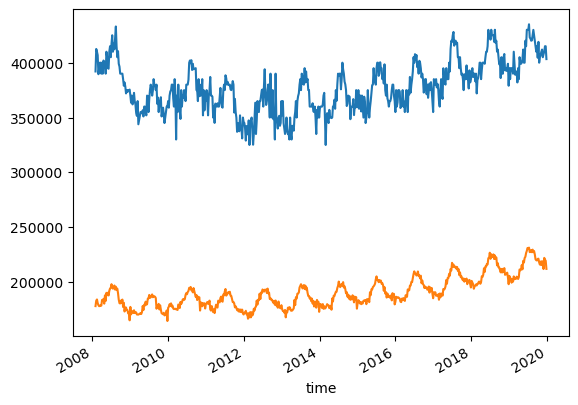

In [733]:
train_data[train_data['RegionName'] == 'New York, NY']['Price'].plot()
train_data[train_data['RegionName'] == 'New York, NY']['Predicted'].plot()

<Axes: xlabel='time'>

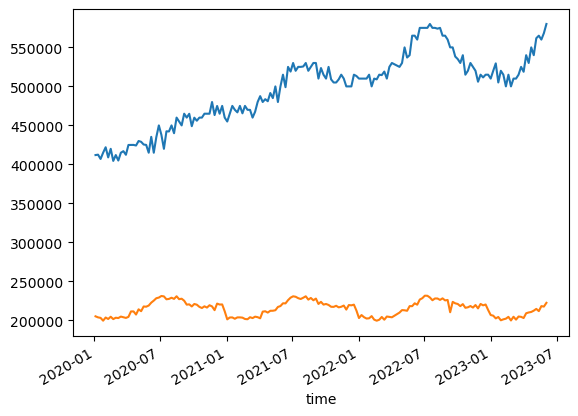

In [748]:
test_data[test_data['RegionName'] == 'New York, NY']['Price'].plot()
test_data[test_data['RegionName'] == 'New York, NY']['Predicted'].plot()

In [749]:
train_data_2 = data_ohe.loc[data_ohe.index < '2017-01-01']
test_data_2 = data_ohe.loc[(data_ohe.index >= '2017-01-01') & (data_ohe.index < '2020-01-01')]

In [750]:
train_data_2 = date_features(train_data_2)
test_data_2 = date_features(test_data_2)

In [751]:
features =  ['year', 'quarter', 'month', 'dayofyear', 'StateName_AL', 'StateName_AR', 'StateName_AZ', 'StateName_CA',
       'StateName_CO', 'StateName_CT', 'StateName_DE', 'StateName_FL',
       'StateName_GA', 'StateName_HI', 'StateName_ID', 'StateName_IL',
       'StateName_IN', 'StateName_KY', 'StateName_LA', 'StateName_MA',
       'StateName_MD', 'StateName_ME', 'StateName_MI', 'StateName_MN',
       'StateName_MO', 'StateName_MS', 'StateName_NC', 'StateName_NE',
       'StateName_NJ', 'StateName_NM', 'StateName_NV', 'StateName_NY',
       'StateName_OH', 'StateName_OK', 'StateName_OR', 'StateName_PA',
       'StateName_RI', 'StateName_SC', 'StateName_TN', 'StateName_TX',
       'StateName_UT', 'StateName_VA', 'StateName_WA', 'StateName_WI',
       'StateName_USA']

target = ['Price']

In [752]:
X_train_2 = train_data_2[features]
y_train_2 = train_data_2['Price']

X_test_2 = test_data_2[features]
y_test_2 = test_data_2['Price']

In [754]:
reg_2 = xgb.XGBRegressor(n_estimators=1000)
reg_2.fit(X_train_2, y_train_2,
        eval_set=[(X_train_2, y_train_2), (X_test_2, y_test_2)],
        early_stopping_rounds=100,
       verbose=True)

[0]	validation_0-rmse:150437.32913	validation_1-rmse:210962.94301
[1]	validation_0-rmse:114395.56448	validation_1-rmse:171625.02566
[2]	validation_0-rmse:91546.56877	validation_1-rmse:146041.13455
[3]	validation_0-rmse:77583.92024	validation_1-rmse:127047.69448
[4]	validation_0-rmse:69514.37340	validation_1-rmse:116501.73403
[5]	validation_0-rmse:64916.00311	validation_1-rmse:109169.23722
[6]	validation_0-rmse:62280.70694	validation_1-rmse:103486.30849


/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:60820.22173	validation_1-rmse:100748.77938
[8]	validation_0-rmse:59922.41903	validation_1-rmse:97347.11772
[9]	validation_0-rmse:59299.58636	validation_1-rmse:95841.63369
[10]	validation_0-rmse:58805.14346	validation_1-rmse:94669.63631
[11]	validation_0-rmse:58425.76403	validation_1-rmse:93591.64640
[12]	validation_0-rmse:58172.94275	validation_1-rmse:92843.01086
[13]	validation_0-rmse:57982.17875	validation_1-rmse:92572.65698
[14]	validation_0-rmse:57769.91350	validation_1-rmse:92011.65313
[15]	validation_0-rmse:57624.96193	validation_1-rmse:91706.85405
[16]	validation_0-rmse:57386.89218	validation_1-rmse:91057.88912
[17]	validation_0-rmse:57228.51072	validation_1-rmse:90845.57370
[18]	validation_0-rmse:57139.59455	validation_1-rmse:90735.22082
[19]	validation_0-rmse:57056.67933	validation_1-rmse:90605.15743
[20]	validation_0-rmse:56962.76331	validation_1-rmse:90427.77227
[21]	validation_0-rmse:56864.75407	validation_1-rmse:89861.32550
[22]	validation_0-rmse:5680

[133]	validation_0-rmse:55925.16565	validation_1-rmse:87805.62041
[134]	validation_0-rmse:55924.85291	validation_1-rmse:87805.75469
[135]	validation_0-rmse:55924.18299	validation_1-rmse:87801.73335
[136]	validation_0-rmse:55923.76144	validation_1-rmse:87803.23169
[137]	validation_0-rmse:55921.98120	validation_1-rmse:87799.67776
[138]	validation_0-rmse:55920.87229	validation_1-rmse:87798.14679
[139]	validation_0-rmse:55920.38489	validation_1-rmse:87797.37728
[140]	validation_0-rmse:55919.15724	validation_1-rmse:87804.45124
[141]	validation_0-rmse:55918.52686	validation_1-rmse:87801.67763
[142]	validation_0-rmse:55917.49928	validation_1-rmse:87806.88703
[143]	validation_0-rmse:55913.55983	validation_1-rmse:87802.11388
[144]	validation_0-rmse:55912.16380	validation_1-rmse:87804.87613
[145]	validation_0-rmse:55909.35856	validation_1-rmse:87800.41022
[146]	validation_0-rmse:55905.43032	validation_1-rmse:87804.74459
[147]	validation_0-rmse:55903.76208	validation_1-rmse:87803.51845
[148]	vali

[258]	validation_0-rmse:55808.45071	validation_1-rmse:87787.11758
[259]	validation_0-rmse:55807.86376	validation_1-rmse:87787.84203
[260]	validation_0-rmse:55807.46058	validation_1-rmse:87787.27196
[261]	validation_0-rmse:55806.67739	validation_1-rmse:87789.25564
[262]	validation_0-rmse:55805.99838	validation_1-rmse:87789.85914
[263]	validation_0-rmse:55805.31923	validation_1-rmse:87787.06769
[264]	validation_0-rmse:55805.21822	validation_1-rmse:87786.90254
[265]	validation_0-rmse:55804.84044	validation_1-rmse:87786.44426
[266]	validation_0-rmse:55804.09455	validation_1-rmse:87786.08439
[267]	validation_0-rmse:55803.61803	validation_1-rmse:87786.75747
[268]	validation_0-rmse:55803.05311	validation_1-rmse:87789.26704
[269]	validation_0-rmse:55802.29610	validation_1-rmse:87788.76733
[270]	validation_0-rmse:55801.74995	validation_1-rmse:87790.10073
[271]	validation_0-rmse:55801.35727	validation_1-rmse:87790.88088
[272]	validation_0-rmse:55801.06473	validation_1-rmse:87789.87939
[273]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [761]:
train_data_2['Predicted'] = reg_2.predict(X_train_2)

In [762]:
test_data_2['Predicted'] = reg_2.predict(X_test_2)

In [764]:
test_data_2

,RegionID,SizeRank,RegionName,RegionType,Price,StateName_AL,StateName_AR,StateName_AZ,StateName_CA,StateName_CO,...,StateName_UT,StateName_VA,StateName_WA,StateName_WI,StateName_USA,year,quarter,month,dayofyear,Predicted
time,,,,,,,,,,,,,,,,,,,,,
2017-01-07,102001,0,United States,country,215000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2017,1,1,7,198846.031250
2017-01-07,394913,1,"New York, NY",msa,385000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2017,1,1,7,183716.109375
2017-01-07,753899,2,"Los Angeles, CA",msa,560000.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2017,1,1,7,404244.343750
2017-01-07,394463,3,"Chicago, IL",msa,205000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2017,1,1,7,128814.843750
2017-01-07,394514,4,"Dallas, TX",msa,228000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2017,1,1,7,162482.843750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,394380,232,"Bend, OR",msa,399999.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2019,4,12,362,270532.437500
2019-12-28,395009,237,"Punta Gorda, FL",msa,194450.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2019,4,12,362,180945.562500
2019-12-28,394960,242,"Panama City, FL",msa,215000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2019,4,12,362,180945.562500


<Axes: xlabel='time'>

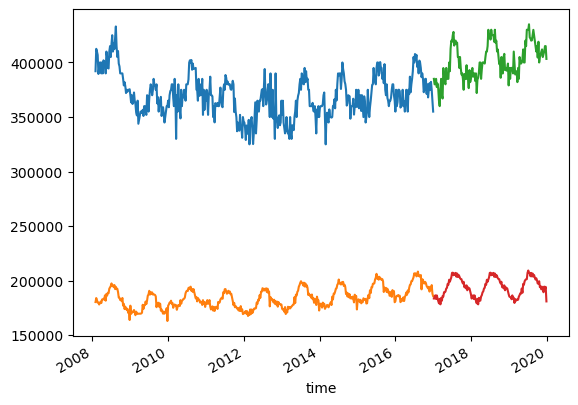

In [774]:
train_data_2[train_data_2['RegionName'] == 'New York, NY']['Price'].plot()
train_data_2[train_data_2['RegionName'] == 'New York, NY']['Predicted'].plot()

test_data_2[test_data_2['RegionName'] == 'New York, NY']['Price'].plot()
test_data_2[test_data_2['RegionName'] == 'New York, NY']['Predicted'].plot()



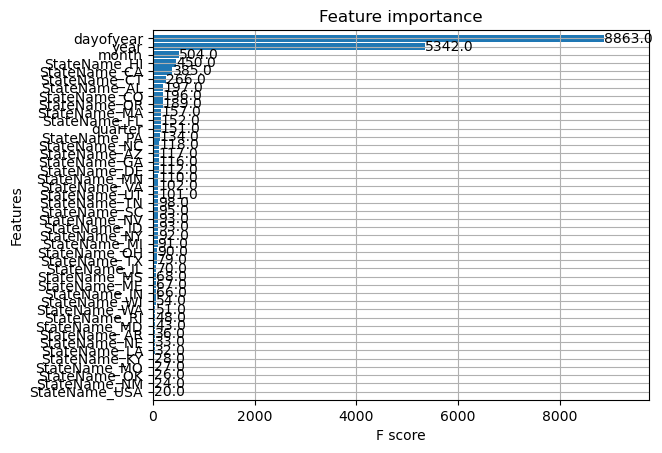

In [712]:
_ = plot_importance(reg, height=0.9)


In [ ]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)


Top Metro Areas

In [781]:
top_5 = list(data_ohe.iloc[1:6, :]['RegionName'])

In [787]:
nyc_data = data_ohe[data_ohe['RegionName'] == top_5[0]]

In [789]:
la_data = data_ohe[data_ohe['RegionName'] == top_5[1]]

# Step 2: Data Preprocessing

In [448]:
top_row = data.iloc[:1]

In [449]:
label_cols = list(data.columns.values[:7])

In [450]:
df_melted = pd.melt(data, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank'], value_vars=['1996-04', '1996-05', '1996-06', '1996-07', '1996-08',
       '1996-09', '1996-10', '1996-11', '1996-12', '1997-01', '1997-02',
       '1997-03', '1997-04', '1997-05', '1997-06', '1997-07', '1997-08',
       '1997-09', '1997-10', '1997-11', '1997-12', '1998-01', '1998-02',
       '1998-03', '1998-04', '1998-05', '1998-06', '1998-07', '1998-08',
       '1998-09', '1998-10', '1998-11', '1998-12', '1999-01', '1999-02',
       '1999-03', '1999-04', '1999-05', '1999-06', '1999-07', '1999-08',
       '1999-09', '1999-10', '1999-11', '1999-12', '2000-01', '2000-02',
       '2000-03', '2000-04', '2000-05', '2000-06', '2000-07', '2000-08',
       '2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02',
       '2001-03', '2001-04', '2001-05', '2001-06', '2001-07', '2001-08',
       '2001-09', '2001-10', '2001-11', '2001-12', '2002-01', '2002-02',
       '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08',
       '2002-09', '2002-10', '2002-11', '2002-12', '2003-01', '2003-02',
       '2003-03', '2003-04', '2003-05', '2003-06', '2003-07', '2003-08',
       '2003-09', '2003-10', '2003-11', '2003-12', '2004-01', '2004-02',
       '2004-03', '2004-04', '2004-05', '2004-06', '2004-07', '2004-08',
       '2004-09', '2004-10', '2004-11', '2004-12', '2005-01', '2005-02',
       '2005-03', '2005-04', '2005-05', '2005-06', '2005-07', '2005-08',
       '2005-09', '2005-10', '2005-11', '2005-12', '2006-01', '2006-02',
       '2006-03', '2006-04', '2006-05', '2006-06', '2006-07', '2006-08',
       '2006-09', '2006-10', '2006-11', '2006-12', '2007-01', '2007-02',
       '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08',
       '2007-09', '2007-10', '2007-11', '2007-12', '2008-01', '2008-02',
       '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08',
       '2008-09', '2008-10', '2008-11', '2008-12', '2009-01', '2009-02',
       '2009-03', '2009-04', '2009-05', '2009-06', '2009-07', '2009-08',
       '2009-09', '2009-10', '2009-11', '2009-12', '2010-01', '2010-02',
       '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08',
       '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02',
       '2011-03', '2011-04', '2011-05', '2011-06', '2011-07', '2011-08',
       '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02',
       '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08',
       '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02',
       '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08',
       '2013-09', '2013-10', '2013-11', '2013-12', '2014-01', '2014-02',
       '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
       '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
       '2018-03', '2018-04'], var_name='Date', value_name='Price')

In [455]:
df_melted

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,Price
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04,77300.0
...,...,...,...,...,...,...,...,...,...
3901590,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,2018-04,209300.0
3901591,59107,3293,Woodstock,NH,Claremont,Grafton,14720,2018-04,225800.0
3901592,75672,40404,Berea,KY,Richmond,Madison,14721,2018-04,133400.0
3901593,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,2018-04,664400.0


In [451]:
df_melted[df_melted['CountyName'] == 'Cook']

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,Price
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04,334200.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04,498100.0
7,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04,216500.0
16,84646,60647,Chicago,IL,Chicago,Cook,17,1996-04,122700.0
19,84620,60618,Chicago,IL,Chicago,Cook,20,1996-04,142600.0
...,...,...,...,...,...,...,...,...,...
3898107,84412,60163,Berkeley,IL,Chicago,Cook,11236,2018-04,180100.0
3898460,84446,60203,Evanston,IL,Chicago,Cook,11589,2018-04,402000.0
3899588,84414,60165,Stone Park,IL,Chicago,Cook,12717,2018-04,156000.0
3900031,84527,60476,Thornton,IL,Chicago,Cook,13160,2018-04,102400.0


In [105]:
df_melted

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,Price
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04,77300.0
...,...,...,...,...,...,...,...,...,...
3901590,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,2018-04,209300.0
3901591,59107,3293,Woodstock,NH,Claremont,Grafton,14720,2018-04,225800.0
3901592,75672,40404,Berea,KY,Richmond,Madison,14721,2018-04,133400.0
3901593,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,2018-04,664400.0


In [106]:
df_mean = df_melted.groupby(['Date']).mean()

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/705390131.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df_melted.groupby(['Date']).mean()


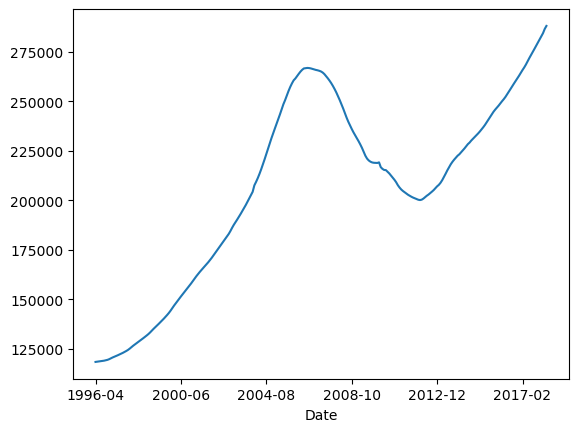

In [107]:
df_mean["Price"].plot();

In [108]:
from statsmodels.graphics.tsaplots import plot_acf

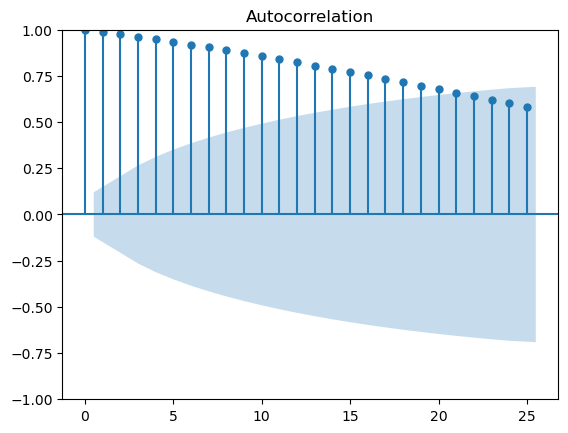

In [109]:
plot_acf(df_mean["Price"])
plt.show()

In [110]:
from statsmodels.tsa.stattools import pacf 
from statsmodels.graphics.tsaplots import plot_pacf

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


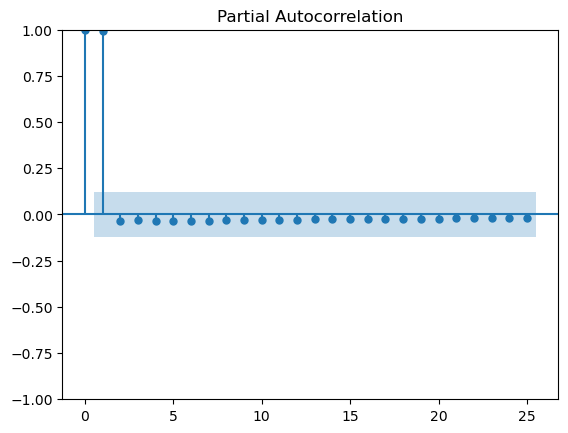

In [111]:
plot_pacf(df_mean["Price"])
plt.show()

In [112]:
df_mean_diff = df_mean['Price'].diff()

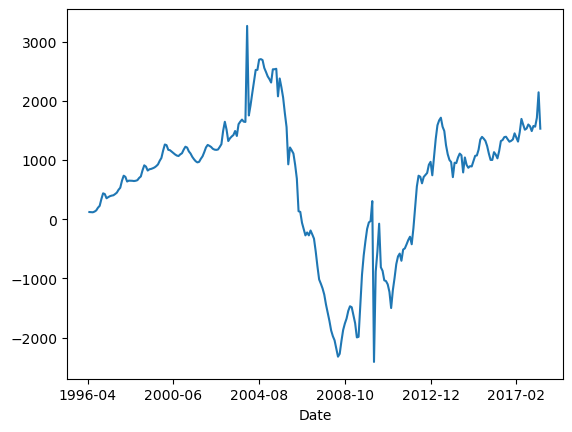

In [113]:
df_mean_diff.plot();

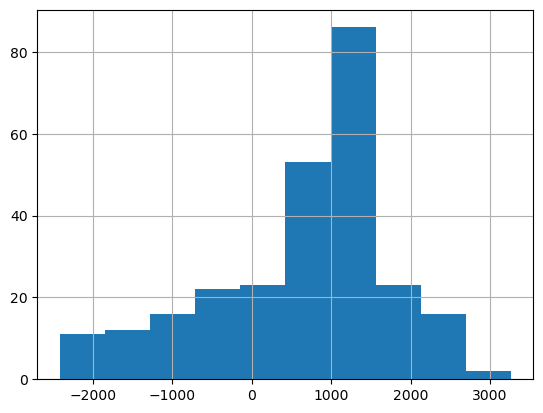

In [114]:
df_mean_diff.hist()
plt.show()

In [115]:
df_melted['Date'] = pd.to_datetime(df_melted['Date'])

In [116]:
df_melted.set_index('Date', inplace = True)

In [117]:
df_melted.sort_values(by=['SizeRank'])

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Price
Date,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
2008-11-01,84654,60657,Chicago,IL,Chicago,Cook,1,824800.0
2009-12-01,84654,60657,Chicago,IL,Chicago,Cook,1,774600.0
2004-09-01,84654,60657,Chicago,IL,Chicago,Cook,1,798200.0
2005-10-01,84654,60657,Chicago,IL,Chicago,Cook,1,870700.0
...,...,...,...,...,...,...,...,...
2008-07-01,95851,89155,Mesquite,NV,Las Vegas,Clark,14723,316000.0
2005-12-01,95851,89155,Mesquite,NV,Las Vegas,Clark,14723,443800.0
2015-03-01,95851,89155,Mesquite,NV,Las Vegas,Clark,14723,289100.0


In [118]:
df_melted.loc

In [119]:
df_chicago = df_melted[df_melted['City'] == 'Chicago']

In [120]:
df_chicago.sort_values(by=['RegionName', 'Date'])

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Price
Date,,,,,,,,
1996-04-01,84607,60605,Chicago,IL,Chicago,Cook,1361,293500.0
1996-05-01,84607,60605,Chicago,IL,Chicago,Cook,1361,293000.0
1996-06-01,84607,60605,Chicago,IL,Chicago,Cook,1361,292500.0
1996-07-01,84607,60605,Chicago,IL,Chicago,Cook,1361,291700.0
1996-08-01,84607,60605,Chicago,IL,Chicago,Cook,1361,290900.0
...,...,...,...,...,...,...,...,...
2017-12-01,84656,60660,Chicago,IL,Chicago,Cook,348,517700.0
2018-01-01,84656,60660,Chicago,IL,Chicago,Cook,348,521500.0
2018-02-01,84656,60660,Chicago,IL,Chicago,Cook,348,524100.0


In [121]:
df_chicago

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Price
Date,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0
1996-04-01,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0
1996-04-01,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0
...,...,...,...,...,...,...,...,...
2018-04-01,84653,60656,Chicago,IL,Chicago,Cook,3157,304000.0
2018-04-01,84652,60655,Chicago,IL,Chicago,Cook,3961,232600.0
2018-04-01,84645,60646,Chicago,IL,Chicago,Cook,4041,401300.0


In [122]:
chi_mean = df_chicago.groupby(['City', 'Date']).mean()

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/2759028472.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chi_mean = df_chicago.groupby(['City', 'Date']).mean()


In [123]:
chi_mean.reset_index(inplace = True)

In [124]:
chi_mean.set_index('Date', inplace = True)

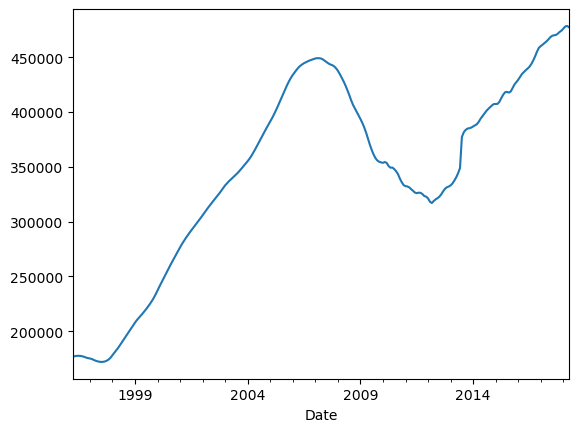

In [125]:
chi_mean['Price'].plot();

In [126]:
chi_mean_first_difference = chi_mean['Price'].diff()

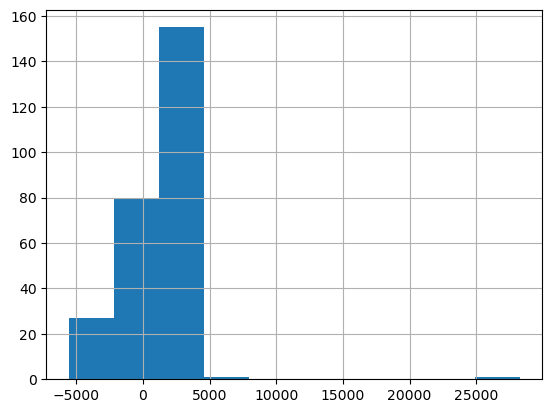

In [127]:
chi_mean_first_difference.hist()
plt.show()

In [128]:
sorted(chi_mean.index)

[Timestamp('1996-04-01 00:00:00'),
 Timestamp('1996-05-01 00:00:00'),
 Timestamp('1996-06-01 00:00:00'),
 Timestamp('1996-07-01 00:00:00'),
 Timestamp('1996-08-01 00:00:00'),
 Timestamp('1996-09-01 00:00:00'),
 Timestamp('1996-10-01 00:00:00'),
 Timestamp('1996-11-01 00:00:00'),
 Timestamp('1996-12-01 00:00:00'),
 Timestamp('1997-01-01 00:00:00'),
 Timestamp('1997-02-01 00:00:00'),
 Timestamp('1997-03-01 00:00:00'),
 Timestamp('1997-04-01 00:00:00'),
 Timestamp('1997-05-01 00:00:00'),
 Timestamp('1997-06-01 00:00:00'),
 Timestamp('1997-07-01 00:00:00'),
 Timestamp('1997-08-01 00:00:00'),
 Timestamp('1997-09-01 00:00:00'),
 Timestamp('1997-10-01 00:00:00'),
 Timestamp('1997-11-01 00:00:00'),
 Timestamp('1997-12-01 00:00:00'),
 Timestamp('1998-01-01 00:00:00'),
 Timestamp('1998-02-01 00:00:00'),
 Timestamp('1998-03-01 00:00:00'),
 Timestamp('1998-04-01 00:00:00'),
 Timestamp('1998-05-01 00:00:00'),
 Timestamp('1998-06-01 00:00:00'),
 Timestamp('1998-07-01 00:00:00'),
 Timestamp('1998-08-

<Axes: xlabel='Date'>

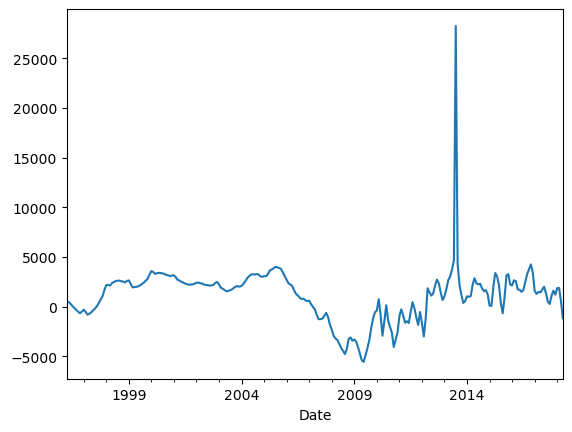

In [129]:
chi_mean_first_difference.plot()

In [130]:
chi_mean

,City,RegionID,RegionName,SizeRank,Price
Date,,,,,
1996-04-01,Chicago,92317.829268,60633.097561,1266.536585,176757.500000
1996-05-01,Chicago,92317.829268,60633.097561,1266.536585,177220.000000
1996-06-01,Chicago,92317.829268,60633.097561,1266.536585,177500.000000
1996-07-01,Chicago,92317.829268,60633.097561,1266.536585,177560.000000
1996-08-01,Chicago,92317.829268,60633.097561,1266.536585,177435.000000
...,...,...,...,...,...
2017-12-01,Chicago,92317.829268,60633.097561,1266.536585,474153.658537
2018-01-01,Chicago,92317.829268,60633.097561,1266.536585,476026.829268
2018-02-01,Chicago,92317.829268,60633.097561,1266.536585,477909.756098


In [131]:
chi_mean_price = chi_mean(columns =['Date', 'Price'])

TypeError: 'DataFrame' object is not callable

In [132]:
chi_mean_price

NameError: name 'chi_mean_price' is not defined

In [133]:
chicago = df_chicago.groupby('City').mean()

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/3104339859.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chicago = df_chicago.groupby('City').mean()


In [134]:
chicago['Price']

City
Chicago    345709.823607
Name: Price, dtype: float64

In [135]:
chi_town_zip = df_melted[df_melted['RegionName'] == 60657]

In [136]:
chi_town_zip.set_index('Date', inplace = True)

KeyError: "None of ['Date'] are in the columns"

In [137]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

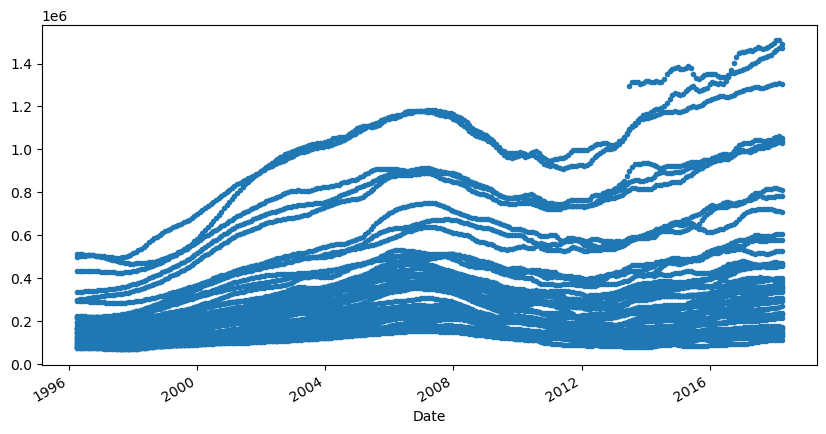

In [138]:
fix, ax = plt.subplots(figsize = (10,5))

#chi_town_zip['Price'].plot(style = '.', color = color_pal[1], title = 'Chicago Zip Pricing')

df_chicago['Price'].plot(style = '.');

In [139]:
df_melted.sort_index()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Price
Date,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0
...,...,...,...,...,...,...,...,...
2018-04-01,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,209300.0
2018-04-01,59107,3293,Woodstock,NH,Claremont,Grafton,14720,225800.0
2018-04-01,75672,40404,Berea,KY,Richmond,Madison,14721,133400.0


In [140]:
reset_inex.sort_values([ 'RegionName', 'Date'])

NameError: name 'reset_inex' is not defined

In [141]:
reset_inex.groupby(['RegionName', 'Price', 'Date']).mean()

NameError: name 'reset_inex' is not defined

In [142]:
reset_inex.set_index('Date')

NameError: name 'reset_inex' is not defined

In [143]:
reset_inex = df_melted

In [144]:
reset_inex.reset_index(inplace = True)

In [145]:
label_cols = data.columns.values[:7]

# Step 3: EDA and Visualization

ConversionError: Failed to convert value(s) to axis units: array(['Chicago', 'McKinney', 'Katy', ..., 'Berea', 'Mount Crested Butte',
       'Mesquite'], dtype=object)

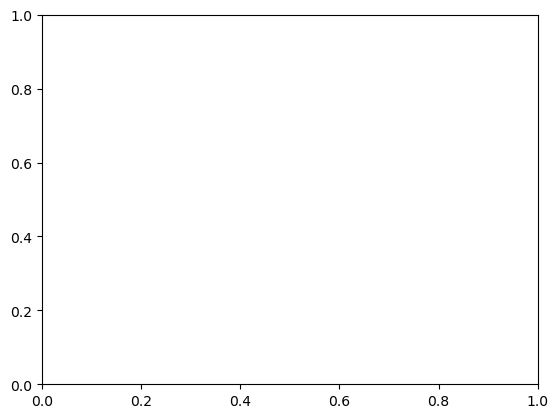

In [146]:
plt.plot(data)

# Step 4: Reshape from Wide to Long Format

In [147]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [148]:
usa_mean = melt_data(data)

In [149]:
type(usa_mean)

pandas.core.frame.DataFrame

In [152]:
usa_mean.rename(columns={"value": "Price"}, inplace = True)

In [153]:
usa_mean

,Price
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312
...,...
2017-12-01,281095.320247
2018-01-01,282657.060382
2018-02-01,284368.688447


In [ ]:
df_melted.index

In [ ]:
df_usa_mean = df_melted.groupby('Date').mean()['Price']

In [ ]:
type(df_usa_mean)

In [ ]:
usa_mean.index

In [ ]:
df_usa_mean

In [ ]:
rolling_mean

In [ ]:
rolling_mean = usa_mean.rolling(window = 6).mean()
rolling_std = usa_mean.rolling(window = 6).std()

In [ ]:
plt.plot(usa_mean, label = 'US National Average')
plt.plot(rolling_mean, label = 'US Quarterly Rolling Mean')
plt.plot(rolling_std, label = 'US Quarterly Rolling STD');

plt.legend();

In [ ]:
from statsmodels.tsa.stattools import adfuller


In [ ]:
adfuller(usa_mean)

In [ ]:
df_usa_mean_diff = usa_mean.diff()

In [ ]:
diff_rolling_mean = df_usa_mean_diff.rolling(window = 6).mean()
dif_rolling_std = df_usa_mean_diff.rolling(window = 6).std()

In [ ]:
plt.plot(df_usa_mean_diff, label = 'US National Average')
plt.plot(diff_rolling_mean, label = 'US Quarterly Rolling Mean')
plt.plot(dif_rolling_std, label = 'US Quarterly Rolling STD');

plt.legend();

In [ ]:
fig, ax = plt.subplots(3,1, figsize = (8,10))

ax[0].plot(usa_mean)
plot_acf(usa_mean, ax = ax[1])
plot_pacf(usa_mean, ax = ax[2])
plt.show()

In [ ]:
df_usa_mean_diff = usa_mean.diff()

In [ ]:
fig, ax = plt.subplots(3,1, figsize = (8,10))

ax[0].plot(df_usa_mean_diff)
plot_acf(df_usa_mean_diff, ax = ax[1])
plot_pacf(df_usa_mean_diff, ax = ax[2])
plt.show()

In [ ]:
usa_mean

In [ ]:
logged_data = np.log(usa_mean)

fix, ax = plt.subplots(2,1)
usa_mean.plot(ax = ax[0], label = 'US Mean Price')
logged_data.plot(ax = ax[1], label = 'US Log of Mean Price')



In [ ]:
result_us = seasonal_decompose(usa_mean, model='multiplicative') # assume multiplicative model

In [ ]:
fig, ax = plt.subplots(3,1, figsize = (8,10))
result_us.trend.plot(ax = ax[0], label = 'trend')
ax[0].legend()
result_us.seasonal.plot(ax = ax[1], label = 'seasonal')
ax[1].legend()
result_us.resid.plot(ax = ax[2], label = 'residual')
ax[2].legend();

In [ ]:
roll_mean = usa_mean.rolling(window=6).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(usa_mean, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
data_minus_roll_mean = usa_mean - roll_mean
data_minus_roll_mean.head(15)

In [ ]:
data_minus_roll_mean.dropna(inplace=True)

In [ ]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

Exponentially Weighted Moving Average
[here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ewm.html).

In [ ]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = usa_mean.ewm(halflife=2).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(usa_mean, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
# Subtract the moving average from the original data
data_minus_exp_roll_mean = usa_mean - exp_roll_mean
data_minus_exp_roll_mean.head(15)

In [ ]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Price - rolling mean')
plt.legend(loc='best')
plt.title('Price while the rolling mean is subtracted')
plt.show(block=False)

In [ ]:
data_diff = usa_mean.diff(periods=1)
data_diff.head(10)

In [ ]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

data.plot(figsize=(18,6), color='blue', linewidth=1, fontsize=14)

In [ ]:
acf(usa_mean, nlags = 5, fft = True)

In [ ]:
plot_acf(usa_mean)
plt.show()

In [ ]:
pacf(usa_mean, nlags = 8)

In [ ]:
plot_pacf(usa_mean)
plt.show();

In [ ]:
result = seasonal_decompose(usa_mean, period = 50)

In [ ]:
result.trend.plot()
plt.show()

In [ ]:
result.resid.plot()
plt.show()

In [ ]:
adfuller(usa_mean)

In [ ]:
usa_mean_diff = usa_mean.diff().dropna()
usa_mean_diff.plot()

Slide Type
Slide
Down-sampling

- '1H': every 1 hour samples
- '2H': every 2 hours, etc
- 'T': minute frequency
- 'S' : second frequency
- 'D': daily
- 'W': weekly
- 'M': monthly

For more frequencies:

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

NOTES

ROI by total time length
ROI each year
compare ROI by city, by zip within city
compare ROI by county
% change in price
risk factors




<Axes: xlabel='time'>

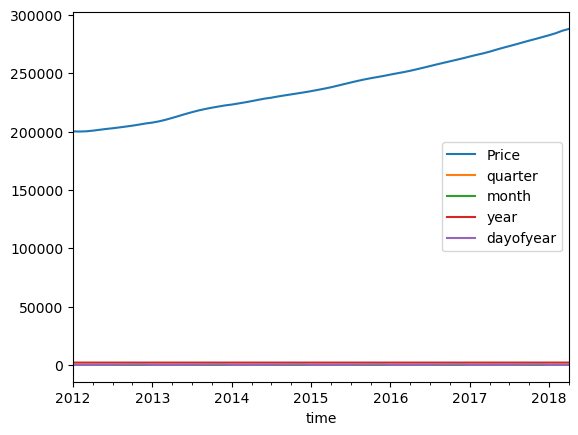

In [437]:
usa_mean.loc['2012':'2018'].plot()

In [438]:
adfuller(usa_mean_diff)

NameError: name 'usa_mean_diff' is not defined

In [ ]:
result_usa = seasonal_decompose(usa_mean_diff, model='additive') 

In [ ]:
%%capture usa_decomposition_plot
fig, ax = plt.subplots(3,1, figsize = (6,6))
result_usa.trend.plot(ax = ax[0], label = 'trend')
ax[0].legend()
result_usa.seasonal.plot(ax = ax[1], label = 'seasonal')
ax[1].legend()
result_usa.resid.plot(ax = ax[2], label = 'residual')
ax[2].legend()

In [ ]:
usa_decomposition_plot()

In [ ]:
reconstruct = result_usa.trend-result_usa.seasonal-result_usa.resid

reconstruct.plot()

In [ ]:
logged_data = np.log(usa_mean)
logged_data.plot()

In [ ]:
usa_mean.plot()

In [ ]:
logged_data.diff(3).plot()
plt.show()

In [ ]:
usa_rolling = usa_mean.rolling(window = 2).mean().dropna()

In [ ]:
log_roll_data = usa_mean - usa_rolling 
log_roll_data.dropna(inplace = True)

adfuller(log_roll_data)

In [ ]:
log_diff_data = logged_data.diff(3).dropna()
adfuller(log_diff_data)

In [ ]:
log_diff_data.plot()

In [ ]:
plot_acf(differenced_data)
plt.show()

In [ ]:
plot_pacf(differenced_data)
plt.show();

In [441]:
exp_roll_mean = np.log(usa_mean).ewm(halflife=4).mean()

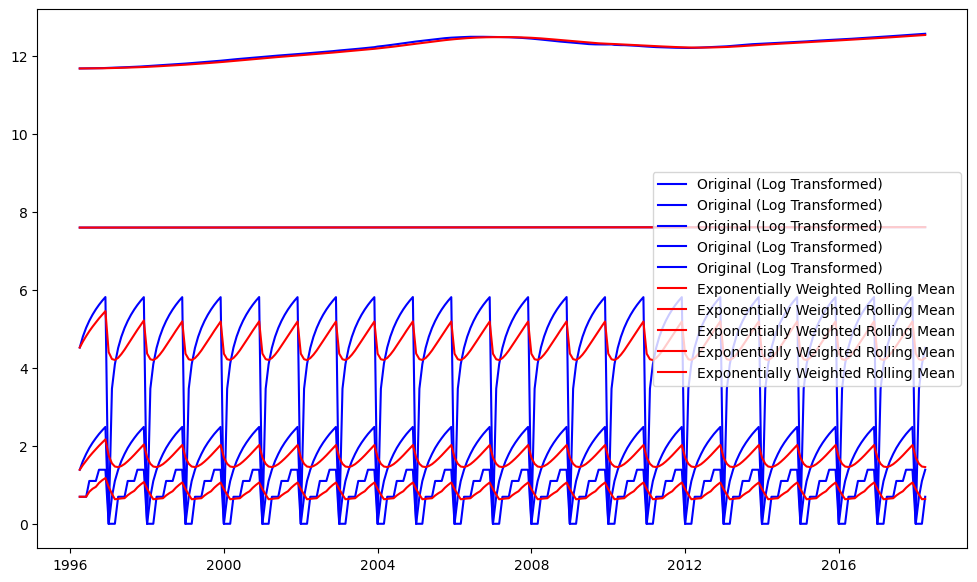

In [442]:
fig = plt.figure(figsize=(12,7))
plt.plot(np.log(usa_mean), color='blue',label='Original (Log Transformed)')
plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.show(block=False)

## (Logged) - (Explonentially Weighted Mean) : np.log(usa_mean) - exp_roll_mean

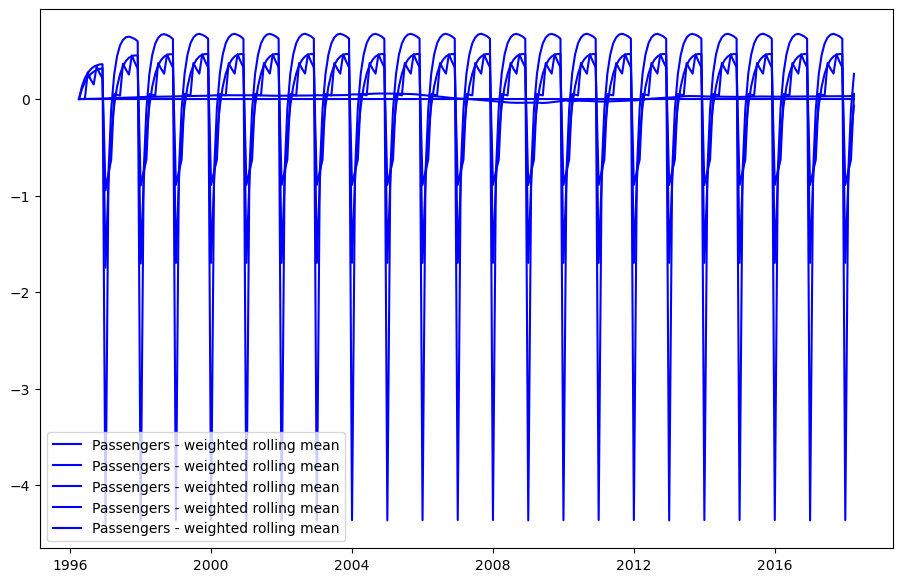

In [443]:
# Subtract the moving average from the original data and check head for Nans
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

# Plot the time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Passengers - weighted rolling mean')
plt.legend(loc='best')
plt.show(block=False)

In [ ]:

def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS)
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None


In [ ]:
stationarity_check(data_minus_exp_roll_mean)

In [ ]:
data_diff = data_minus_exp_roll_mean.diff(periods=3)

# Drop the missing values
data_diff.dropna(inplace=True)

# Check out the first few rows
data_diff.head(15)

In [ ]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='US Price - rolling mean')
plt.legend(loc='best')
plt.title('Differenced passengers series')
plt.show(block=False)

In [ ]:
stationarity_check(data_diff)


In [ ]:
# Exponentially Weighted Mean
exp_roll_mean = np.log(usa_mean).ewm(halflife=2).mean()

# Logged - EWM
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

# Differencing of (Logged - EWM)
data_diff_4 = data_minus_exp_roll_mean.diff(periods=4)

# Drop the missing values
diff_log_exp_mean_4 = data_diff_4.dropna()


In [ ]:
adfuller(diff_log_exp_mean_4)

In [ ]:
# Exponentially Weighted Mean
exp_roll_mean = np.log(usa_mean).ewm(halflife=2).mean()

# Logged - EWM
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

# Differencing of (Logged - EWM)
data_diff_9 = data_minus_exp_roll_mean.diff(periods=9)

# Drop the missing values
diff_log_exp_mean_9 = data_diff_9.dropna()

In [ ]:
adfuller(diff_log_exp_mean_9)

In [ ]:
def try_diffed_log_minus_ewm(TS):

    min_p = 1
    
    for i, k in itertools.product(range(1,8), range(1,13)):
        exp_roll_mean = np.log(TS).ewm(halflife = i).mean()

        # Logged - EWM
        data_minus_exp_roll_mean = np.log(TS) - exp_roll_mean

        # Differencing of (Logged - EWM)
        data_diff = data_minus_exp_roll_mean.diff(periods = k)

        # Drop the missing values
        diff_log_exp_mean = data_diff.dropna()
        
        p = adfuller(diff_log_exp_mean)[1]
        
        if p < min_p:
            min_p = p
        
        print(min_p)
        print(f'Half Life: {i} ; Diff Period : {k} \nP Value {p}\n')


In [ ]:
try_diffed_log_minus_ewm(usa_mean)

In [ ]:
def best_diffed_log_minus_ewm(TS):

    min_p = 1
    
    for i, k in itertools.product(range(1,8), range(1,13)):
        exp_roll_mean = np.log(TS).ewm(halflife = i).mean()

        # Logged - EWM
        data_minus_exp_roll_mean = np.log(TS) - exp_roll_mean

        # Differencing of (Logged - EWM)
        data_diff = data_minus_exp_roll_mean.diff(periods = k)

        # Drop the missing values
        diff_log_exp_mean = data_diff.dropna()
        
        p = adfuller(diff_log_exp_mean)[1]
        
        if p < min_p:
            min_p = p
        
            print(min_p)
            print(f'Half Life: {i} ; Diff Period : {k} \nP Value {p}\n')

In [ ]:
best_diffed_log_minus_ewm(usa_mean)

In [ ]:
def try_diff1_log_minus_ewm(TS):

    min_p = 1
    
    for i in range(1,8):
        exp_roll_mean = np.log(TS).ewm(halflife = i).mean()

        # Logged - EWM
        data_minus_exp_roll_mean = np.log(TS) - exp_roll_mean

        # Differencing of (Logged - EWM)
        data_diff = data_minus_exp_roll_mean.diff

        # Drop the missing values
        diff_log_exp_mean = data_diff.dropna()
        
        p = adfuller(diff_log_exp_mean)[1]
        
        if p < min_p:
            min_p = p
        
        print(min_p)
        print(f'Half Life: {i} ; Diff \nP Value {p}\n')

### Made Stationary With:


In [ ]:
exp_roll_mean = np.log(usa_mean).ewm(halflife = 3).mean()

# Logged - EWM
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

logewm_log_min_mean_diff = data_minus_exp_roll_mean.diff().dropna()

In [ ]:
logewm_log_min_mean_diff

In [ ]:
adfuller(logewm_log_min_mean_diff)

## Modeling

In [ ]:
logewm_log_min_mean_diff

In [ ]:
(2018 - 1995)*.2

In [ ]:
split = '2014'

train_arma11 = logewm_log_min_mean_diff[: '2013']
test_arma11 = logewm_log_min_mean_diff['2014':]
print(train_arma11.shape, test_arma11.shape)

In [ ]:
train_arma11

In [ ]:
model = ARIMA(train_arma11, order = (1, 0, 1))
results = model.fit();

In [ ]:
results.summary()

In [ ]:
dict(zip(results.param_names, results.params))

In [ ]:
n_len = train_arma11.shape[0]


insamp_pred = results.predict(0, n_len)

#get first 5 values in-sample
insamp_pred[0:5]

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_arma11, label = 'data')
ax.plot(insamp_pred, label = 'ARMA(1,0,1) fit')
ax.legend()

In [ ]:
test_arma11.shape

In [ ]:
test_arma11.index

In [ ]:
forecast = results.get_forecast(52) # returns an object
predmean = forecast.predicted_mean # the mean
pred_conf = forecast.conf_int() # this gets the 95% confidence interval

In [ ]:
fig, ax = plt.subplots()
ax.plot(predmean, label='Forecast')
ax.plot(test_arma11[0:52], label = 'data')
ax.legend()
plt.show()

In [ ]:
plt.plot(results.forecast(0,52), label = 'forecast')
plt.plot(test_arma11[0:52], label = 'data')
plt.axvspan(0,3, alpha = 0.5)
plt.title('Out of sample Forecast')
plt.legend();

In [ ]:
results.plot_diagnostics(figsize = (12,5))
plt.tight_layout()
plt.show()

In [ ]:
residuals_arma11 = results.resid
plt.plot(residuals_arma11);

In [ ]:
modl = pm.auto_arima(train_arma11, start_p=1, start_q=4,
                     max_p=4, max_q=4, d= 0, trace=True, stepwise=True, suppress_warnings=True,
                     error_action='ignore')

In [ ]:
train_arma11

In [ ]:
model_2 = ARIMA(train_arma11, order = (0, 0, 0))
results_2 = model_2.fit();

In [ ]:
results_2.summary()

In [ ]:
results_2.plot_diagnostics(figsize = (10,10))
plt.show()

In [ ]:
forecast.results

In [ ]:
predmean

In [ ]:
results_2.forecast(52)

In [ ]:
forecast = results_2.get_forecast(52) # returns an object
predmean = forecast.predicted_mean # the mean
pred_conf = forecast.conf_int() # this gets the 95% confidence interval

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_arma11, label = 'data')
ax.plot(insamp_pred, label = 'ARMA(1,0,1) fit')
ax.legend();

In [ ]:
plt.plot(test_arma11)
plt.plot(results.forecast(52));

In [ ]:
forecast = results_2.get_forecast(52) # returns an object
predmean = forecast.predicted_mean # the mean
pred_conf = forecast.conf_int() # this gets the 95% confidence interval

In [ ]:
fig, ax = plt.subplots()
ax.plot(predmean, label='Forecast')
ax.plot(test_arma11[0:52], label = 'data')
ax.legend()
plt.show()

In [ ]:
chicago_price = chicago['Price']

In [ ]:
exp_roll_mean_chi = np.log(chicago_price).ewm(halflife = 3).mean()

        # Logged - EWM
data_minus_exp_roll_mean_chi = np.log(chicago_price) - exp_roll_mean

logewm_log_min_mean_diff_chi = data_minus_exp_roll_mean.diff().dropna()

In [ ]:
adfuller(logewm_log_min_mean_diff_chi)

In [ ]:
exp_roll_mean = np.log(usa_mean).ewm(halflife = 4).mean()

        # Logged - EWM
data_minus_exp_roll_mean = np.log(usa_mean) - exp_roll_mean

In [ ]:
data_minus_exp_roll_mean.diff().plot()

In [ ]:
adfuller(data_minus_exp_roll_mean.diff().dropna())

In [ ]:
#fig, ax = plt.subplots(figsize = (12,6))
result = seasonal_decompose(usa_mean, model='additive')
result.plot()
plt.show()

In [ ]:
result = seasonal_decompose(usa_mean, model='additive')

result.resid.hist();

In [ ]:
resid = result.resid.dropna()

In [ ]:
normalized_resid=(resid-resid.mean())/resid.std()

In [ ]:
normalized_resid.hist()

In [ ]:
df_chi_price = chicago['Price']

In [ ]:
#fig, ax = plt.subplots(figsize = (12,6))
result_chi = seasonal_decompose(df_chi_price, model='additive')
result_chi.plot()
plt.show()

In [ ]:
result_chi = seasonal_decompose(df_chi_price, model='additive')

result.resid.hist();

In [ ]:
model = ARIMA(train_arma11, order = (1, 0, 1))


In [ ]:
log_roll_mean = np.log(usa_mean).rolling(window=7).mean()

In [ ]:
data_minus_roll_mean = np.log(usa_mean) - log_roll_mean

In [ ]:
data_minus_roll_mean.plot()

In [ ]:
data_minus_roll_mean

In [ ]:
adfuller(data_minus_roll_mean.dropna())

In [ ]:
data_minus_exp_roll_mean.plot()

In [ ]:
diff_log_exp_mean.plot();

In [ ]:
usa_mean['20']

In [ ]:
n_test = '2013'
train_arma11 = usa_mean.loc[:,n_test]
test_arma11 = usa_mean.loc[n_test,:]

In [ ]:
model = ARIMA(train_arma11, order = (1, 1, 1))
results = model.fit()

In [ ]:
results.summary()

In [ ]:
n_test = '2013'
train_arma11_diff = log_diff_data.loc[:,n_test]
test_arma11_diff = log_diff_data.loc[n_test,:];

In [ ]:
model = ARIMA(train_arma11, order = (1, 1, 1))
results = model.fit();

In [ ]:
modl = pm.auto_arima(train_arma11, start_p=1, start_q=1,
                     max_p=5, max_q=5, d= 1, trace=True, stepwise=True, suppress_warnings=True,
                     error_action='ignore')

In [ ]:
chicago_zips = df_melted[df_melted['City'] == 'Chicago']

In [ ]:
chicago_zips.reset_index(inplace = True)

In [ ]:
chicago = chicago_zips.groupby(['Date', 'City']).mean()

In [ ]:
chicago = chicago.reset_index()


In [ ]:
chicago.set_index('Date', inplace = True)

In [ ]:
chicago_price = pd.DataFrame(chicago['Price'])

In [ ]:
chicago_price.plot();

In [ ]:
result_chicago = seasonal_decompose(chicago_price, model='multiplicative') # assume multiplicative model

In [ ]:
fig, ax = plt.subplots(3,1, figsize = (8,10))
result_chicago.trend.plot(ax = ax[0], label = 'trend')
ax[0].legend()
result_chicago.seasonal.plot(ax = ax[1], label = 'seasonal')
ax[1].legend()
result_chicago.resid.plot(ax = ax[2], label = 'residual')
ax[2].legend();

In [ ]:
chicago_zips

In [ ]:
df_chicago['RegionName']

# Step 5: ARIMA Modeling

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
cook = df_melted[df_melted['CountyName'] =='Cook']

In [ ]:
price = cook['Price']

In [ ]:
price.plot(kind='line', figsize=(15,10));

In [ ]:
df_melted.index

In [ ]:
usa_mean.head()

In [ ]:
split_date = '2014-01-01'
usamean_train = usa_mean.loc[usa_mean.index <= split_date].copy()
usamean_test = usa_mean.loc[usa_mean.index > split_date].copy()

In [ ]:
usamean_train

In [ ]:
plt.plot(usamean_train)
plt.plot(usamean_test);

In [ ]:
_ = usamean_test \
    .rename(columns={'value': 'TEST SET'}) \
    .join(usamean_train.rename(columns={'value': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='USA Mean Price', style='.')

In [ ]:
def date_features(df):
    """
    Data features for time series analysis
    """
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear

    return df

In [ ]:
X_train, y_train = create_features(usamean_train, label='House Price')
X_test, y_test = create_features(usamean_test, label='House Price')


In [335]:
X_train

,year,quarter,month,dayofyear
time,,,,
1996-04-01,1996,2,4,92
1996-05-01,1996,2,5,122
1996-06-01,1996,2,6,153
1996-07-01,1996,3,7,183
1996-08-01,1996,3,8,214
...,...,...,...,...
2014-08-01,2014,3,8,213
2014-09-01,2014,3,9,244
2014-10-01,2014,4,10,274


## XGBoost Regressor

In [420]:
usa_mean

,Price,quarter,month,year,dayofyear
time,,,,,
1996-04-01,118299.123063,2,4,1996,92
1996-05-01,118419.044139,2,5,1996,122
1996-06-01,118537.423268,2,6,1996,153
1996-07-01,118653.069278,3,7,1996,183
1996-08-01,118780.254312,3,8,1996,214
...,...,...,...,...,...
2017-12-01,281095.320247,4,12,2017,335
2018-01-01,282657.060382,1,1,2018,1
2018-02-01,284368.688447,1,2,2018,32


In [421]:
train = usa_mean.loc[usa_mean.index < '2015-01-01']
test = usa_mean.loc[usa_mean.index >= '2015-01-01']

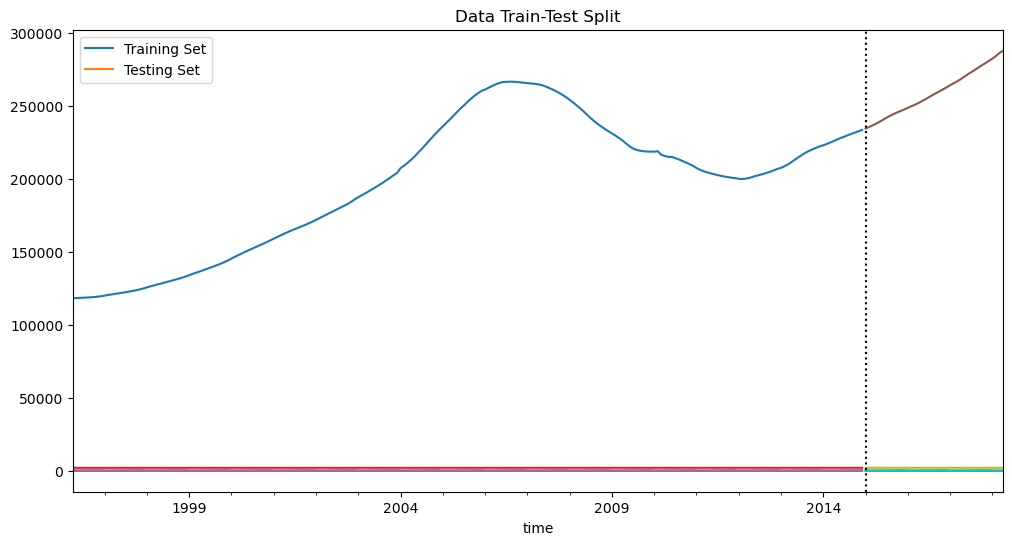

In [422]:
fig,ax = plt.subplots(figsize = (12,6))

train.plot(ax = ax, label = 'Training Set', title = 'Data Train-Test Split')
test.plot(ax = ax, label = 'Testing Set')
ax.axvline('2015-01-01', color = 'black', ls = ':')
ax.legend(['Training Set', 'Testing Set'])
plt.show();

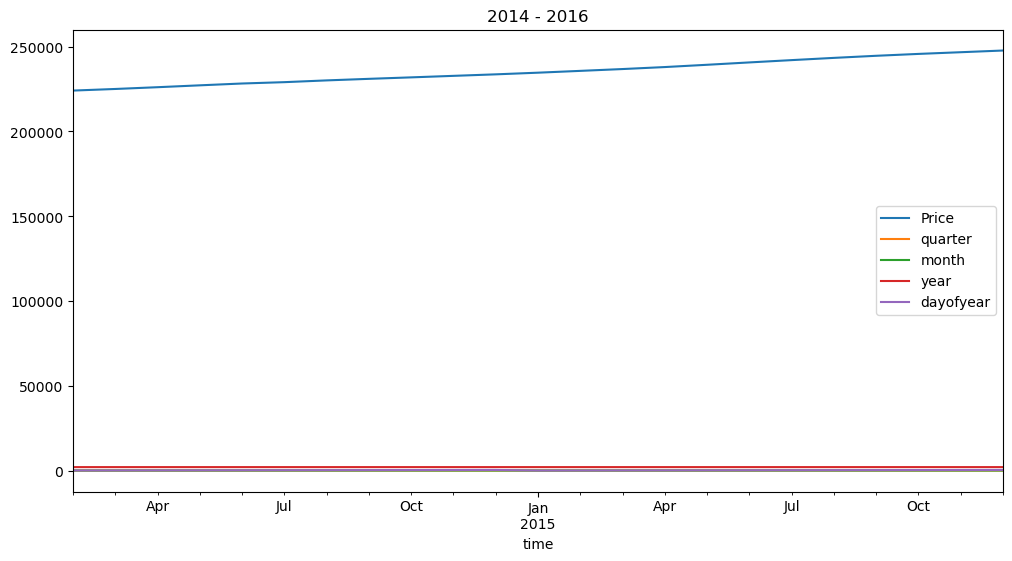

In [423]:
usa_mean.loc[(usa_mean.index > '2014') & (usa_mean.index < '2016')].plot(figsize = (12,6), title = '2014 - 2016')
plt.show();

In [424]:
usa_mean

,Price,quarter,month,year,dayofyear
time,,,,,
1996-04-01,118299.123063,2,4,1996,92
1996-05-01,118419.044139,2,5,1996,122
1996-06-01,118537.423268,2,6,1996,153
1996-07-01,118653.069278,3,7,1996,183
1996-08-01,118780.254312,3,8,1996,214
...,...,...,...,...,...
2017-12-01,281095.320247,4,12,2017,335
2018-01-01,282657.060382,1,1,2018,1
2018-02-01,284368.688447,1,2,2018,32


In [425]:
def date_features(df):
    """
    Data features for time series analysis
    """
    df = df.copy()
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear

    return df

In [426]:
usa_mean_features = date_features(usa_mean)

In [427]:
usa_mean_features

,Price,quarter,month,year,dayofyear
time,,,,,
1996-04-01,118299.123063,2,4,1996,92
1996-05-01,118419.044139,2,5,1996,122
1996-06-01,118537.423268,2,6,1996,153
1996-07-01,118653.069278,3,7,1996,183
1996-08-01,118780.254312,3,8,1996,214
...,...,...,...,...,...
2017-12-01,281095.320247,4,12,2017,335
2018-01-01,282657.060382,1,1,2018,1
2018-02-01,284368.688447,1,2,2018,32


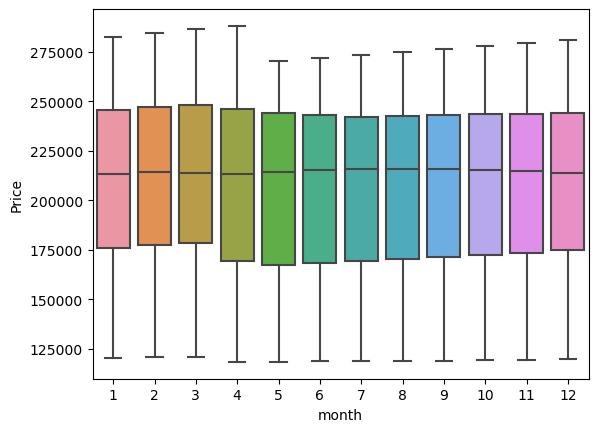

In [415]:
sns.boxplot(data = usa_mean_features, x = 'month', y = 'Price');

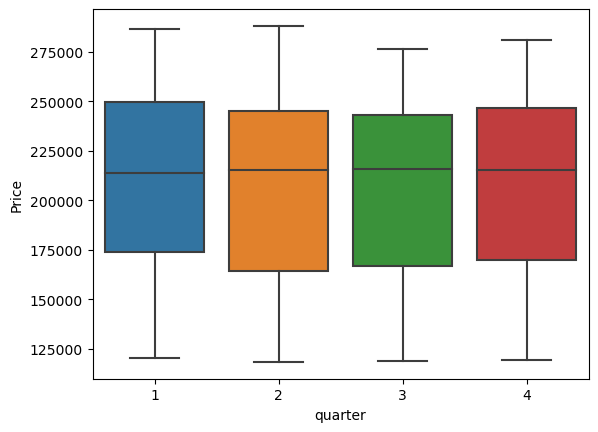

In [416]:
sns.boxplot(data = usa_mean_features, x = 'quarter', y = 'Price');

Don't see much a any seasonal change in house pricing

XBG MODEL #1

In [428]:
train

,Price,quarter,month,year,dayofyear
time,,,,,
1996-04-01,118299.123063,2,4,1996,92
1996-05-01,118419.044139,2,5,1996,122
1996-06-01,118537.423268,2,6,1996,153
1996-07-01,118653.069278,3,7,1996,183
1996-08-01,118780.254312,3,8,1996,214
...,...,...,...,...,...
2014-08-01,230141.744210,3,8,2014,213
2014-09-01,231060.035319,3,9,2014,244
2014-10-01,231927.514773,4,10,2014,274


In [433]:
train = date_features(train)
test = date_features(test)

In [431]:
features =  ['year', 'quarter', 'month', 'dayofyear']
target = ['Price']

In [435]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [436]:
xbg_model = xgb.XGBRegressor(n_estimartors = 1000, early_stopping_rounds = 50) #lerning_rate = 0.01

xbg_model.fit(X_train, y_train, 
              eval_set = [(x_train, y_train), (X_test, y_test)],
              verbose = True) #verbose = 100

[13:06:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "n_estimartors" } are not used.

[0]	validation_0-rmse:142974.97531	validation_1-rmse:192424.59731
[1]	validation_0-rmse:101161.72895	validation_1-rmse:149098.89413
[2]	validation_0-rmse:71673.92854	validation_1-rmse:118673.72435
[3]	validation_0-rmse:50936.96517	validation_1-rmse:96868.74306
[4]	validation_0-rmse:36354.85697	validation_1-rmse:80364.45459
[5]	validation_0-rmse:26150.94893	validation_1-rmse:69710.43225
[6]	validation_0-rmse:18797.90508	validation_1-rmse:59737.72072
[7]	validation_0-rmse:13692.03462	validation_1-rmse:52599.52958
[8]	validation_0-rmse:9968.12722	validation_1-rmse:47493.97852
[9]	validation_0-rmse:7335.79633	validation_1-rmse:43842.09365
[10]	validation_0-rmse:5431.76782	validation_1-rmse:41516.73370
[11]	validation_0-rmse:4073.35539	validation_1-rmse:39750.17676
[12]	validation_0-rmse:3094.78999	validation_1-rmse:38485.94042
[13]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimartors=1000, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [224]:
feat_import = pd.DataFrame(xbg_model.feature_importances_,
             index = xbg_model.feature_names_in_,
            columns = ['importance'])

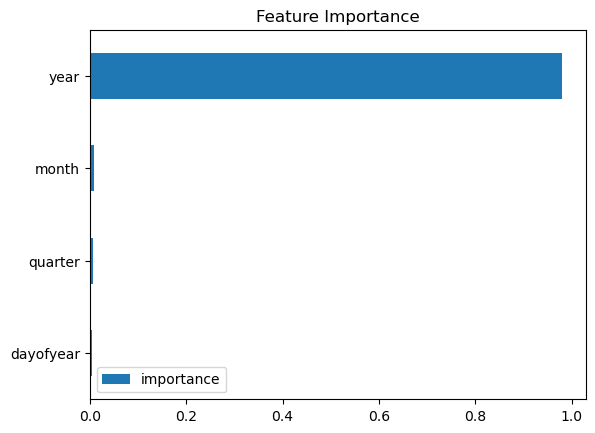

In [196]:
feat_import.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance');

In [228]:
test.head()

,Price,year,quarter,month,dayofyear,prediction,error
time,,,,,,,
2015-01-01,234691.190654,2015,1,1,1,223166.312500,11524.878154
2015-02-01,235760.279834,2015,1,2,32,224180.875000,11579.404834
2015-03-01,236836.426000,2015,1,3,60,225000.796875,11835.629125
2015-04-01,238009.760239,2015,2,4,91,226174.000000,11835.760239
2015-05-01,239354.207702,2015,2,5,121,227264.703125,12089.504577


In [445]:
test['prediction'] = xbg_model.predict(X_test)

In [202]:
usa_mean_features = usa_mean_features.merge(test[['prediction']] , how = 'left', left_index = True, right_index = True)

In [204]:
usa_mean_features

,Price,quarter,month,year,dayofyear,prediction
time,,,,,,
1996-04-01,118299.123063,2,4,1996,92,NaN
1996-05-01,118419.044139,2,5,1996,122,NaN
1996-06-01,118537.423268,2,6,1996,153,NaN
1996-07-01,118653.069278,3,7,1996,183,NaN
1996-08-01,118780.254312,3,8,1996,214,NaN
...,...,...,...,...,...,...
2017-12-01,281095.320247,4,12,2017,335,233643.906250
2018-01-01,282657.060382,1,1,2018,1,223166.312500
2018-02-01,284368.688447,1,2,2018,32,224180.875000


KeyError: 'prediction'

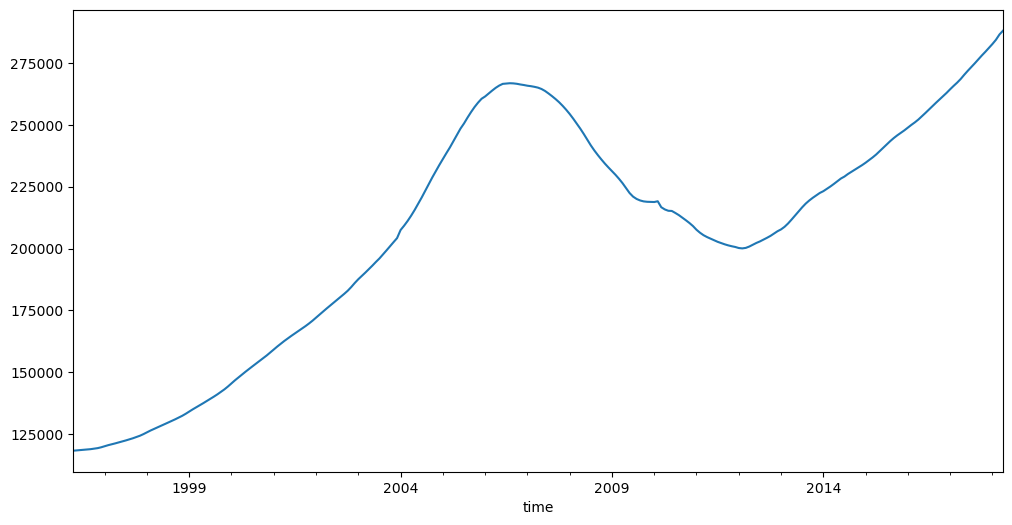

In [446]:
fig,ax = plt.subplots(figsize = (12,6))

usa_mean_features['Price'].plot(ax = ax)
usa_mean_features['prediction'].plot(ax = ax)
ax.axvline('2015-01-01', color = 'black', ls = ':')
plt.show();

In [212]:
rmse_score = np.sqrt(mean_squared_error(test['Price'], test['prediction']))
print(f'First XGB Score on Test set: {rmse_score:0.2f}')

First XGB Score on Test set: 34951.64


In [216]:
test['error'] = np.abs(test['Price'] - test['prediction'])

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/3254342177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = np.abs(test['Price'] - test['prediction'])


In [217]:
test

,Price,year,quarter,month,dayofyear,prediction,error
time,,,,,,,
2015-01-01,234691.190654,2015,1,1,1,223166.312500,11524.878154
2015-02-01,235760.279834,2015,1,2,32,224180.875000,11579.404834
2015-03-01,236836.426000,2015,1,3,60,225000.796875,11835.629125
2015-04-01,238009.760239,2015,2,4,91,226174.000000,11835.760239
2015-05-01,239354.207702,2015,2,5,121,227264.703125,12089.504577
2015-06-01,240744.121443,2015,2,6,152,228303.656250,12440.465193
2015-07-01,242103.525097,2015,3,7,182,229180.234375,12923.290722
2015-08-01,243424.444746,2015,3,8,213,230093.875000,13330.569746
2015-09-01,244658.269374,2015,3,9,244,231095.390625,13562.878749


XBG Model #2

In [252]:
train_2 = train
test_2 = test

In [249]:
X_train_2 = train[features]
y_train_2 = train[target]

X_test_2 = test[features]
y_test_2 = test[target]

In [269]:
xbg_model_2 = xgb.XGBRegressor(n_estimartors = 1000, early_stopping_rounds = 50, learning_rate = 0.1)

xbg_model_2.fit(X_train, y_train, 
              eval_set = [(X_train_2, y_train_2), (X_test_2, y_test_2)],
              verbose = True) #verbose = 100

[11:15:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "n_estimartors" } are not used.

[0]	validation_0-rmse:182582.31754	validation_1-rmse:237382.25886
[1]	validation_0-rmse:164721.82895	validation_1-rmse:217129.66275
[2]	validation_0-rmse:148643.50679	validation_1-rmse:200229.90383
[3]	validation_0-rmse:134157.26664	validation_1-rmse:185004.38969
[4]	validation_0-rmse:121101.51148	validation_1-rmse:171288.21249
[5]	validation_0-rmse:109306.46105	validation_1-rmse:158932.68170
[6]	validation_0-rmse:98699.24719	validation_1-rmse:148003.63645
[7]	validation_0-rmse:89088.95310	validation_1-rmse:137996.13657
[8]	validation_0-rmse:80431.72499	validation_1-rmse:128983.65877
[9]	validation_0-rmse:72666.46183	validation_1-rmse:120170.40594
[10]	validation_0-rmse:65635.33211	validation_1-rmse:112777.43650
[11]	validation_0-rmse:59319.07530	validation_1-rmse:106427.62042
[12]	validation_0-rmse:53630.82880	validation_1-rmse:100

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimartors=1000, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [277]:
train_2['prediction'] = xbg_model_2.predict(X_train_2)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/2620336206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2['prediction'] = xbg_model_2.predict(X_train_2)


In [270]:
test_2['prediction'] = xbg_model_2.predict(X_test_2)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/4270824535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2['prediction'] = xbg_model_2.predict(X_test_2)


In [256]:
usa_mean_features = usa_mean_features.merge(test_2[['prediction']] , how = 'left', left_index = True, right_index = True)

In [257]:
usa_mean_features

,Price,quarter,month,year,dayofyear,prediction_x,prediction_y
time,,,,,,,
1996-04-01,118299.123063,2,4,1996,92,NaN,NaN
1996-05-01,118419.044139,2,5,1996,122,NaN,NaN
1996-06-01,118537.423268,2,6,1996,153,NaN,NaN
1996-07-01,118653.069278,3,7,1996,183,NaN,NaN
1996-08-01,118780.254312,3,8,1996,214,NaN,NaN
...,...,...,...,...,...,...,...
2017-12-01,281095.320247,4,12,2017,335,136763.1875,136763.1875
2018-01-01,282657.060382,1,1,2018,1,136763.1875,136763.1875
2018-02-01,284368.688447,1,2,2018,32,136763.1875,136763.1875


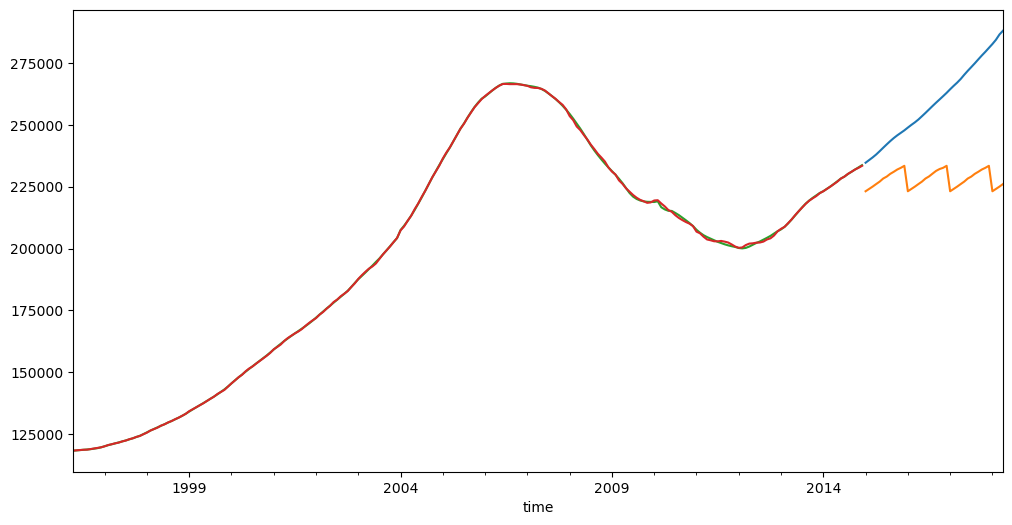

In [282]:
fig,ax = plt.subplots(figsize = (12,6))

test_2['Price'].plot()
test_2['prediction'].plot()
train_2['Price'].plot()
train_2['prediction'].plot()
plt.show();

XGB Model #3

In [310]:
train_3 = train
test_3 = test

In [311]:
X_train_3 = train[features]
y_train_3 = train[target]

X_test_3 = test[features]
y_test_3 = test[target]

In [312]:
xbg_model_3 = xgb.XGBRegressor(n_estimartors = 1000, early_stopping_rounds = 50, learning_rate = .4)

xbg_model_3.fit(X_train_3, y_train_3, 
              eval_set = [(X_train_3, y_train_3), (X_test_3, y_test_3)],
              verbose = True) #verbose = 100

[11:23:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "n_estimartors" } are not used.

[0]	validation_0-rmse:123239.94727	validation_1-rmse:169969.56716
[1]	validation_0-rmse:75367.95254	validation_1-rmse:121138.40251
[2]	validation_0-rmse:46332.68446	validation_1-rmse:91722.79643
[3]	validation_0-rmse:28838.78539	validation_1-rmse:73725.51762
[4]	validation_0-rmse:18139.39270	validation_1-rmse:60776.05805
[5]	validation_0-rmse:11538.34373	validation_1-rmse:50884.02659
[6]	validation_0-rmse:7495.74558	validation_1-rmse:44740.25121
[7]	validation_0-rmse:5026.57710	validation_1-rmse:41537.67454
[8]	validation_0-rmse:3478.53159	validation_1-rmse:39183.00903
[9]	validation_0-rmse:2513.10912	validation_1-rmse:37701.24183
[10]	validation_0-rmse:1895.72260	validation_1-rmse:36780.86794
[11]	validation_0-rmse:1498.37001	validation_1-rmse:36285.13496
[12]	validation_0-rmse:1284.20693	validation_1-rmse:35832.83073
[13]	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimartors=1000, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [313]:
train_3['prediction'] = xbg_model_3.predict(X_train_3)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/1972770825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_3['prediction'] = xbg_model_3.predict(X_train_3)


In [314]:
test_3['prediction'] = xbg_model_3.predict(X_test_3)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/949620656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_3['prediction'] = xbg_model_3.predict(X_test_3)


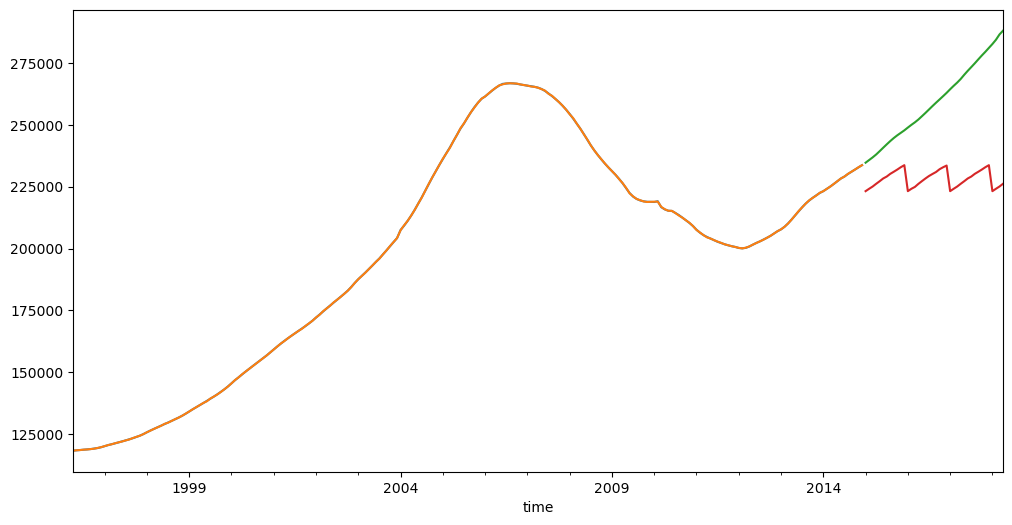

In [320]:
fig,ax = plt.subplots(figsize = (12,6))

train_3['Price'].plot(ax = ax)
train_3['prediction'].plot(ax = ax)

test_3['Price'].plot(ax = ax)
test_3['prediction'].plot(ax = ax)

plt.show();

In [321]:
train_3

,Price,quarter,month,year,dayofyear,prediction
time,,,,,,
1996-04-01,118299.123063,2,4,1996,92,118268.093750
1996-05-01,118419.044139,2,5,1996,122,118443.906250
1996-06-01,118537.423268,2,6,1996,153,118533.304688
1996-07-01,118653.069278,3,7,1996,183,118697.531250
1996-08-01,118780.254312,3,8,1996,214,118769.554688
...,...,...,...,...,...,...
2014-08-01,230141.744210,3,8,2014,213,230182.546875
2014-09-01,231060.035319,3,9,2014,244,231033.203125
2014-10-01,231927.514773,4,10,2014,274,231918.656250


Change Model to Only Use More Recent Years

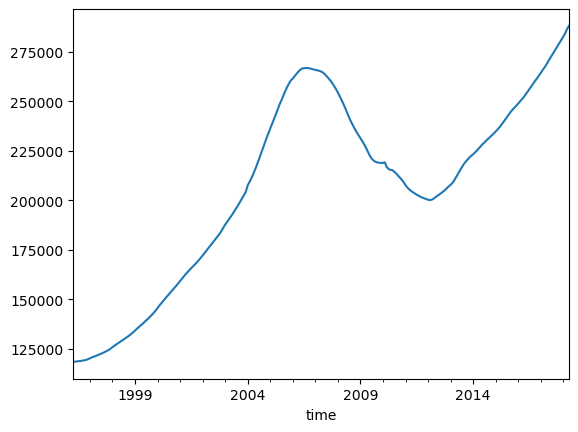

In [357]:
usa_mean['Price'].plot();

In [388]:
us_after_crash = usa_mean.loc['2009':]

In [389]:
us_after_crash.shape

(112, 5)

In [390]:
train_4 = us_after_crash.loc[us_after_crash.index < '2016-01-01']
test_4 = us_after_crash.loc[us_after_crash.index >= '2016-01-01']

In [391]:
train_4.shape

(84, 5)

In [392]:
test_4.shape

(28, 5)

In [393]:
train_with_features_4 = date_features(train_4)
test_with_features_4 = date_features(test_4)

In [396]:
train_with_features_4

,Price,quarter,month,year,dayofyear
time,,,,,
2009-01-01,231308.672892,1,1,2009,1
2009-02-01,229820.522071,1,2,2009,32
2009-03-01,228199.285512,1,3,2009,60
2009-04-01,226440.435767,2,4,2009,91
2009-05-01,224442.204301,2,5,2009,121
...,...,...,...,...,...
2015-08-01,243424.444746,3,8,2015,213
2015-09-01,244658.269374,3,9,2015,244
2015-10-01,245764.565646,4,10,2015,274


In [399]:
X_train_4 = train_with_features_4[features]
y_train_4 = train_with_features_4[target]

X_test_4 = test_with_features_4[features]
y_test_4 = test_with_features_4[target]

In [400]:
xbg_model_4 = xgb.XGBRegressor(n_estimartors = 1000, early_stopping_rounds = 50, learning_rate = .4)

xbg_model_4.fit(X_train_4, y_train_4, 
              eval_set = [(X_train_4, y_train_4), (X_test_4, y_test_4)],
              verbose = True) #verbose = 100

[11:42:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "n_estimartors" } are not used.

[0]	validation_0-rmse:132777.56207	validation_1-rmse:181182.68738
[1]	validation_0-rmse:80985.63754	validation_1-rmse:129114.36348
[2]	validation_0-rmse:49865.78556	validation_1-rmse:92326.31897
[3]	validation_0-rmse:31135.60833	validation_1-rmse:69778.20418
[4]	validation_0-rmse:19605.70622	validation_1-rmse:54214.99946
[5]	validation_0-rmse:12554.13881	validation_1-rmse:44504.50096
[6]	validation_0-rmse:8224.98874	validation_1-rmse:38456.11675
[7]	validation_0-rmse:5511.97807	validation_1-rmse:35188.11718
[8]	validation_0-rmse:3747.81501	validation_1-rmse:33075.73343
[9]	validation_0-rmse:2656.79461	validation_1-rmse:31746.58731
[10]	validation_0-rmse:1866.91144	validation_1-rmse:30903.69658
[11]	validation_0-rmse:1397.02206	validation_1-rmse:30346.50018
[12]	validation_0-rmse:1059.09316	validation_1-rmse:29985.98648
[13]	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimartors=1000, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [401]:
y_train_4

,Price
time,
2009-01-01,231308.672892
2009-02-01,229820.522071
2009-03-01,228199.285512
2009-04-01,226440.435767
2009-05-01,224442.204301
...,...
2015-08-01,243424.444746
2015-09-01,244658.269374
2015-10-01,245764.565646


In [402]:
train_4['prediction'] = xbg_model_4.predict(X_train_4)
test_4['prediction'] = xbg_model_4.predict(X_test_4)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/2394090962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_4['prediction'] = xbg_model_4.predict(X_train_4)
/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1256/2394090962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_4['prediction'] = xbg_model_4.predict(X_test_4)


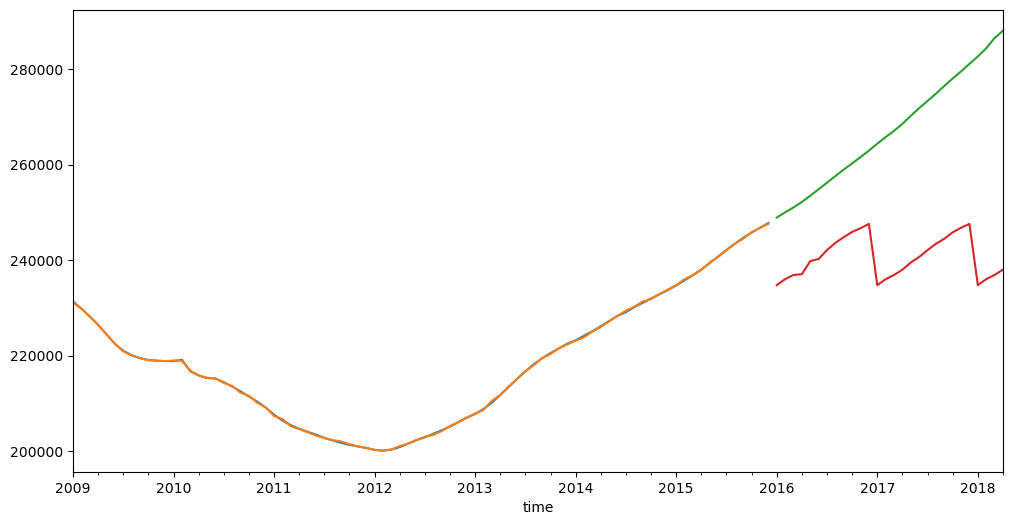

In [403]:
fig,ax = plt.subplots(figsize = (12,6))

train_4['Price'].plot(ax = ax)
train_4['prediction'].plot(ax = ax)

test_4['Price'].plot(ax = ax)
test_4['prediction'].plot(ax = ax)

plt.show();